Welcome to Santiago's Jupyter Notebook for accessing climate data. This script was created with the help of the original script provided by the course instructor for Royal Roads ENSC304- Earth and Atmospheric Science found [here](https://github.com/mbexhrs3/UCW-Project/blob/master/RRU-2021_UCW_project_Sept_2021.ipynb). Further aid was used from a tutorial [found here](https://www.ubcenvision.com/blog/2017/11/30/jupyter-part1.html). 

# Library Imports
As with any other python script, first we need to import the necessary libraries. Keep in mind that if you are using this script in your local environment, you may need to install the libraries before execution using either pip or conda.

In [1]:
import pandas as pd
import datetime
from datetime import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pymannkendall as mk
from mk_test import mk_test


# Functions
Functions in python are a great way to be able to re-use code, avoid lenghty and redundant code. For our case, I created three different functions that allow us to find stations based on the station ids which can be found in this website.

### Station Metadata Function
This function uses the environment canada API to access the station metadata. The function returns a dataframe with the station properties. This includes the types of data available, data ranges, coordinates, and other useful information.

In [2]:
def stationmetadata(s_id):
    # Start with an empty dictionary to add data to
    station_props = []
    url = "https://api.weather.gc.ca/collections/climate-stations/items?f=json&lang=en-CA&limit=10&STN_ID={}".format(
        s_id
    )
    # Now the headers needed to recieve the application format. In this case, the data arrives in geojson (json)
    headers = {"ACCEPT": "application/geo+json"}
    # Send a GET request to the API
    request = requests.get(url, headers=headers)
    request_json = request.json()
    print(request_json)
    # Get the properties of the stations
    data = request_json['features'][0]['properties']
    # Create a dataframe from the json data
    station_df = pd.json_normalize(data)
    station_props.append(station_df)
    # Concatenate the stations to the stations dataframe
    stations_df = pd.concat(station_props)
    return stations_df

In [4]:
station_numbers = [1070, 636, 888]
test = stationmetadata(station_numbers)


{'code': 'NoApplicableCode', 'description': 'query error (check logs)'}


KeyError: 'features'

Let's test the function to make sure that it works.

In [5]:
van_meta = stationmetadata(888)
pg_meta = stationmetadata(636)
vernon_meta = stationmetadata(1070)

station_metadata = pd.concat([van_meta, pg_meta, vernon_meta], ignore_index=True)
station_metadata


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'STN_ID': 888, 'STATION_NAME': 'VANCOUVER HARBOUR CS', 'PROV_STATE_TERR_CODE': 'BC', 'ENG_PROV_NAME': 'BRITISH COLUMBIA', 'FRE_PROV_NAME': 'COLOMBIE-BRITANNIQUE', 'COUNTRY': 'CAN', 'LATITUDE': 491743270, 'LONGITUDE': -1230718730, 'TIMEZONE': 'PST', 'ELEVATION': '2.50', 'CLIMATE_IDENTIFIER': '1108446', 'TC_IDENTIFIER': 'WHC', 'WMO_IDENTIFIER': '71201', 'STATION_TYPE': 'Climate-Auto', 'NORMAL_CODE': 'D', 'PUBLICATION_CODE': 1, 'DISPLAY_CODE': 5, 'ENG_STN_OPERATOR_ACRONYM': 'ECCC - MSC', 'FRE_STN_OPERATOR_ACRONYM': 'ECCC - SMC', 'ENG_STN_OPERATOR_NAME': 'Environment and Climate Change Canada - Meteorological Service of Canada', 'FRE_STN_OPERATOR_NAME': 'Environnement et Changement climatique Canada - Service météorologique du Canada', 'FIRST_DATE': '1925-01-01 00:00:00', 'LAST_DATE': '2023-02-22 08:30:07', 'HLY_FIRST_DATE': '1976-01-20 07:00:00', 'HLY_LAST_DATE': '2023-02-22 08:30:07', 'DLY_FIRST_DATE': '1925-11

,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,ELEVATION,...,LAST_DATE,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA
0,888,VANCOUVER HARBOUR CS,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,491743270,-1230718730,PST,2.50,...,2023-02-22 08:30:07,1976-01-20 07:00:00,2023-02-22 08:30:07,1925-11-01 00:00:00,2023-02-21 00:00:00,1925-01-01 00:00:00,2007-02-01 00:00:00,Y,N,Y
1,636,PRINCE GEORGE STP,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,535248000,-1224603000,PST,579.00,...,2022-12-29 00:00:00,None,None,1975-11-01 00:00:00,2022-12-29 00:00:00,1975-01-01 00:00:00,2007-02-01 00:00:00,Y,Y,N
2,1070,VERNON SILVER STAR LODGE,BC,BRITISH COLUMBIA,COLOMBIE-BRITANNIQUE,CAN,502132500,-1190322300,PST,1585.60,...,2023-02-13 00:00:00,None,None,1970-07-01 00:00:00,2023-02-13 00:00:00,1970-01-01 00:00:00,2007-02-01 00:00:00,Y,N,N


### Get Data function
This function is used for downloading the available data from the environment canada historical data api, based on a station ID and a start year. The result of this function is a dataframe built from a csv downloaded.

In [6]:
def getData(stationID, year, month):
    #Build the URL for query
    base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
    query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=3".format(stationID, year, month)
    api_endpoint = base_url + query_url
    print(api_endpoint)
    # Create a dataframe by reading the csv
    return pd.read_csv(api_endpoint, skiprows=0)
    



### Station Data function
This function used the previous two functions to create a dataframe from provided station IDs. Then, the function looks for stations which have monthly data available, finds the data date ranges, and uses those results to download the available data.

In [7]:
from dateutil import rrule
def get_station_data(station_id):
    frames = []
    for stn in station_id:
      print(stn)
      station_meta = stationmetadata(stn)
        
      start_date_full = station_meta.query('STN_ID == @stn').iloc[0]['MLY_FIRST_DATE']
      

      end_date_full = station_meta.query('STN_ID == @stn').iloc[0]['MLY_LAST_DATE']
      

      start_date = datetime.strptime(start_date_full, '%Y-%m-%d %H:%M:%S')
      
      end_date = datetime.strptime(end_date_full, '%Y-%m-%d %H:%M:%S')
      
      for dt in mdates.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
        df = getData(stationID=stn, year=dt.year, month=dt.month)
        frames.append(df)

    return frames
    


# Accesing the Data
In this section, we demosntrate how to recieve a user input for station IDs, and then use that for accessing the data using our functions above.

In [10]:
input_id = input("Please enter the station separated by a space: ")
station_ids = input_id.split()
stations = [int(station) for station in station_ids]
print(stations)
#731
weather_data_compiled = get_station_data(stations)


[1053, 636, 731]
1053
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'STN_ID': 1053, 'STATION_NAME': 'PENTICTON A', 'PROV_STATE_TERR_CODE': 'BC', 'ENG_PROV_NAME': 'BRITISH COLUMBIA', 'FRE_PROV_NAME': 'COLOMBIE-BRITANNIQUE', 'COUNTRY': 'CAN', 'LATITUDE': 492747000, 'LONGITUDE': -1193608000, 'TIMEZONE': 'PST', 'ELEVATION': '344.40', 'CLIMATE_IDENTIFIER': '1126150', 'TC_IDENTIFIER': 'YYF', 'WMO_IDENTIFIER': '71889', 'STATION_TYPE': 'Aviation-Staffed', 'NORMAL_CODE': 'A', 'PUBLICATION_CODE': 1, 'DISPLAY_CODE': 1, 'ENG_STN_OPERATOR_ACRONYM': None, 'FRE_STN_OPERATOR_ACRONYM': None, 'ENG_STN_OPERATOR_NAME': None, 'FRE_STN_OPERATOR_NAME': None, 'FIRST_DATE': '1941-01-01 00:00:00', 'LAST_DATE': '2012-05-10 10:00:00', 'HLY_FIRST_DATE': '1953-01-01 00:00:00', 'HLY_LAST_DATE': '2012-05-10 10:00:00', 'DLY_FIRST_DATE': '1941-04-01 00:00:00', 'DLY_LAST_DATE': '2012-05-10 00:00:00', 'MLY_FIRST_DATE': '1941-01-01 00:00:00', 'MLY_LAST_DATE': '2012-05-01 00:00:00', 'HAS_MON

In [11]:
weather_dataframe = pd.concat(weather_data_compiled)
weather_dataframe

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-119.60,49.46,PENTICTON A,1126150,1941-01,1941,1,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
1,-119.60,49.46,PENTICTON A,1126150,1941-02,1941,2,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
2,-119.60,49.46,PENTICTON A,1126150,1941-03,1941,3,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
3,-119.60,49.46,PENTICTON A,1126150,1941-04,1941,4,18.3,NaN,3.2,...,0.0,NaN,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-119.60,49.46,PENTICTON A,1126150,1941-05,1941,5,19.6,NaN,7.0,...,0.0,NaN,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-10,2006,10,11.9,NaN,7.2,...,0.0,NaN,147.7,NaN,0.0,NaN,NaN,NaN,NaN,NaN
502,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-11,2006,11,6.6,E,2.0,...,36.5,I,589.5,I,NaN,M,NaN,NaN,NaN,NaN
503,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-12,2006,12,6.2,NaN,2.1,...,9.0,NaN,221.6,NaN,0.0,NaN,NaN,NaN,NaN,NaN
504,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2007-01,2007,1,4.7,NaN,0.3,...,48.0,NaN,415.6,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Now let's make sure that we have the data we want by running a quick check of the station names

In [14]:
weather_dataframe['Station Name'].unique()
weather_dataframe.drop_duplicates()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Mean Max Temp (°C),Mean Max Temp Flag,Mean Min Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow Grnd Last Day (cm),Snow Grnd Last Day Flag,Dir of Max Gust (10's deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-119.60,49.46,PENTICTON A,1126150,1941-01,1941,1,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
1,-119.60,49.46,PENTICTON A,1126150,1941-02,1941,2,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
2,-119.60,49.46,PENTICTON A,1126150,1941-03,1941,3,NaN,M,NaN,...,NaN,M,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN
3,-119.60,49.46,PENTICTON A,1126150,1941-04,1941,4,18.3,NaN,3.2,...,0.0,NaN,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-119.60,49.46,PENTICTON A,1126150,1941-05,1941,5,19.6,NaN,7.0,...,0.0,NaN,24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-10,2006,10,11.9,NaN,7.2,...,0.0,NaN,147.7,NaN,0.0,NaN,NaN,NaN,NaN,NaN
502,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-11,2006,11,6.6,E,2.0,...,36.5,I,589.5,I,NaN,M,NaN,NaN,NaN,NaN
503,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2006-12,2006,12,6.2,NaN,2.1,...,9.0,NaN,221.6,NaN,0.0,NaN,NaN,NaN,NaN,NaN
504,-122.92,49.28,BURNABY SIMON FRASER U,1101158,2007-01,2007,1,4.7,NaN,0.3,...,48.0,NaN,415.6,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Explore the data that we just recieved, and find the first values after NAs

In [18]:
#Filter the data with dataframes
weather_data_vancouver = weather_dataframe[weather_dataframe['Station Name'] == 'BURNABY SIMON FRASER U']
weather_data_pg = weather_dataframe[weather_dataframe['Station Name'] == 'PRINCE GEORGE STP']
weather_data_pencticton = weather_dataframe[weather_dataframe['Station Name'] == 'PENTICTON A']

van_clean = weather_data_vancouver.drop_duplicates()
pg_clean = weather_data_pg.drop_duplicates()
penticton_clean = weather_data_pencticton.drop_duplicates()



## Data Quality
During this section, we can quickly explore the data, find NaN values, rename columns, and fill in empty values with median values.

In [20]:
# First lets make a quick function that will explore the data tables for us

def data_explorer(dataframe):
  print("The Head of the dataframe")
  print(dataframe.head())
  print("The Data description/summary")
  print(dataframe.describe())
  print("Null Values")
  print(dataframe.isnull().sum())

In [22]:

data_explorer(van_clean)


The Head of the dataframe
   Longitude (x)  Latitude (y)            Station Name  Climate ID Date/Time  \
0        -122.92         49.28  BURNABY SIMON FRASER U     1101158   1965-01   
1        -122.92         49.28  BURNABY SIMON FRASER U     1101158   1965-02   
2        -122.92         49.28  BURNABY SIMON FRASER U     1101158   1965-03   
3        -122.92         49.28  BURNABY SIMON FRASER U     1101158   1965-04   
4        -122.92         49.28  BURNABY SIMON FRASER U     1101158   1965-05   

   Year  Month  Mean Max Temp (°C) Mean Max Temp Flag  Mean Min Temp (°C)  \
0  1965      1                 NaN                  M                 NaN   
1  1965      2                 5.0                NaN                 0.8   
2  1965      3                 9.4                NaN                 2.5   
3  1965      4                11.4                NaN                 5.1   
4  1965      5                13.5                NaN                 6.4   

   ... Total Snow (cm)  Total 

In [23]:
# Here we get the features we want in our dataframe
features = ['Station Name', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Year', 'Month', 'Mean Temp (°C)', 'Total Rain (mm)']
df_vancouver = van_clean[features]
df_vancouver.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)

df_pg = pg_clean[features]
df_pg.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)

df_pencticton = penticton_clean[features]
df_pencticton.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
                   'Total Rain (mm)': 'Total_Rain'}, inplace=True)



C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3244818818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vancouver.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3244818818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pg.rename(columns={'Station Name': 'Station_Name', 'Longitude (x)': 'lon', 'Latitude (y)': 'lat', 'Mean Temp (°C)': 'Mean_Temp',
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3244818818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [24]:
df_vancouver.isnull().sum()

Station_Name     0
Climate ID       0
lon              0
lat              0
Year             0
Month            0
Mean_Temp       15
Total_Rain      17
dtype: int64

In [25]:
df_pg.isnull().sum()

Station_Name     0
Climate ID       0
lon              0
lat              0
Year             0
Month            0
Mean_Temp       11
Total_Rain      11
dtype: int64

In [26]:
df_pencticton.isnull().sum()

Station_Name    0
Climate ID      0
lon             0
lat             0
Year            0
Month           0
Mean_Temp       4
Total_Rain      4
dtype: int64

But how do we know where the null values end? A graph of the data provides us the fastest visual solution. We first need to add a datetime column for graphing.

In [27]:
df_vancouver['datetime'] = pd.to_datetime(df_vancouver[['Year', 'Month']].assign(DAY=1))
df_pg['datetime'] = pd.to_datetime(df_pg[['Year', 'Month']].assign(DAY=1))
df_pencticton['datetime'] = pd.to_datetime(df_pencticton[['Year', 'Month']].assign(DAY=1))

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\717934413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vancouver['datetime'] = pd.to_datetime(df_vancouver[['Year', 'Month']].assign(DAY=1))
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\717934413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pg['datetime'] = pd.to_datetime(df_pg[['Year', 'Month']].assign(DAY=1))
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\717934413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

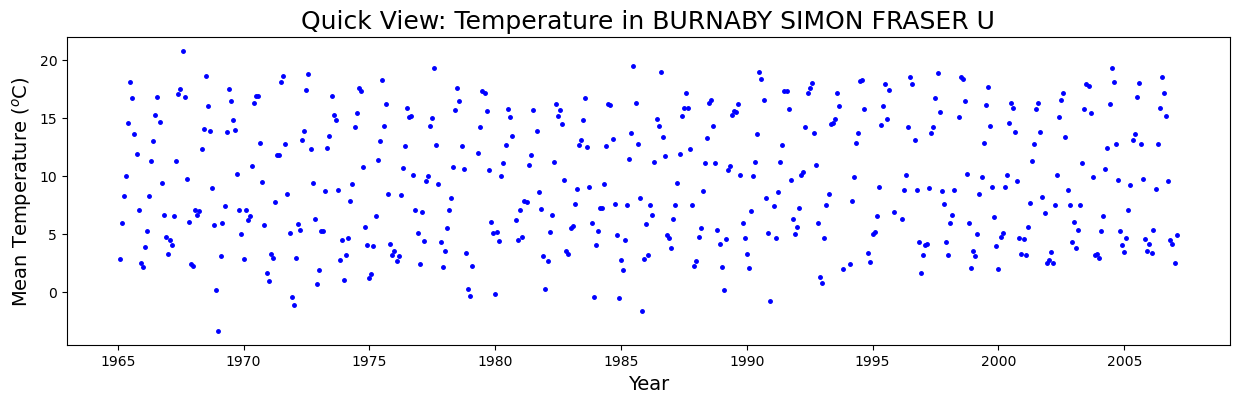

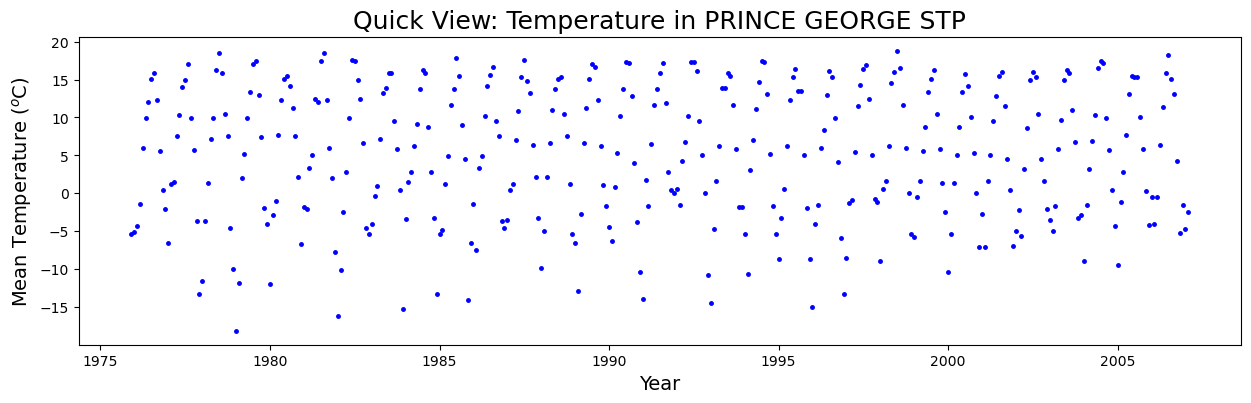

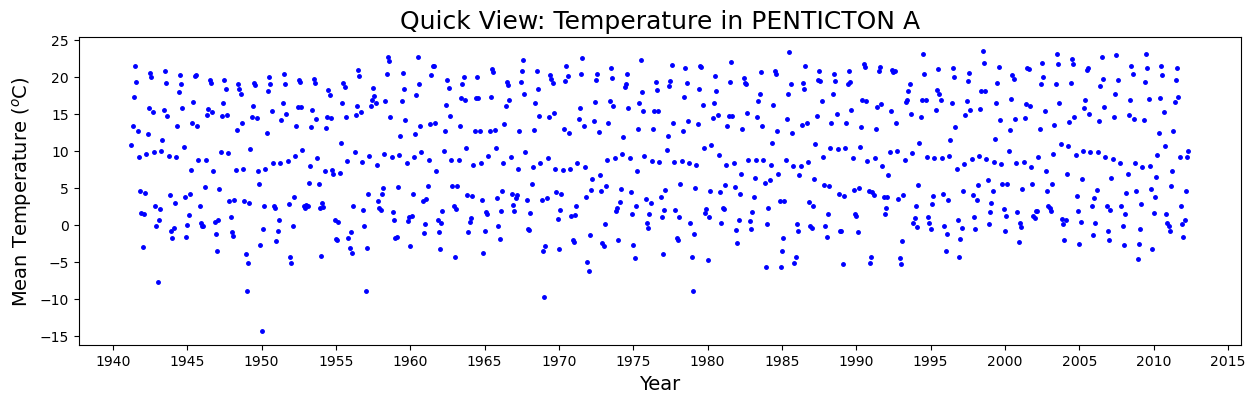

In [28]:
def graph_temp(dataframe):
  fig = plt.figure(figsize=(15,4))
  ax = fig.add_subplot(111)
  ax.plot(dataframe['datetime'],dataframe['Mean_Temp'], marker='.', markersize=5, color='b', linestyle='None')

  loc = mdates.YearLocator(5)
  ax.xaxis.set_major_locator(loc)
  fmt = mdates.DateFormatter('%Y')
  ax.xaxis.set_major_formatter(fmt)

  plt.xlabel('Year', fontsize=14)
  plt.ylabel('Mean Temperature ($^o$C)', fontsize=14)
  plt.title('Quick View: Temperature in {}'.format(dataframe.iloc[0]['Station_Name']), fontsize=18)
  plt.axis('tight')
  plt.show()

graph_temp(df_vancouver)
graph_temp(df_pg)
graph_temp(df_pencticton)

Now we will do the same with precipitation

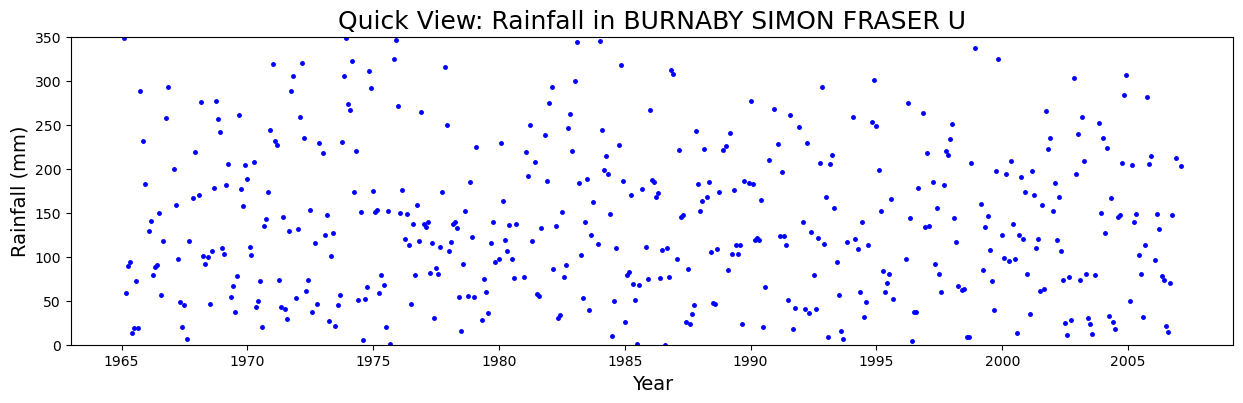

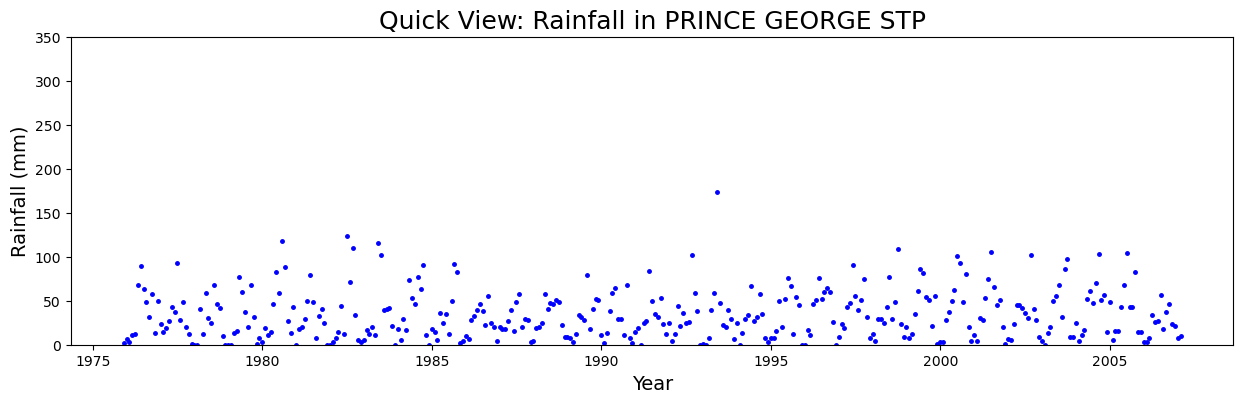

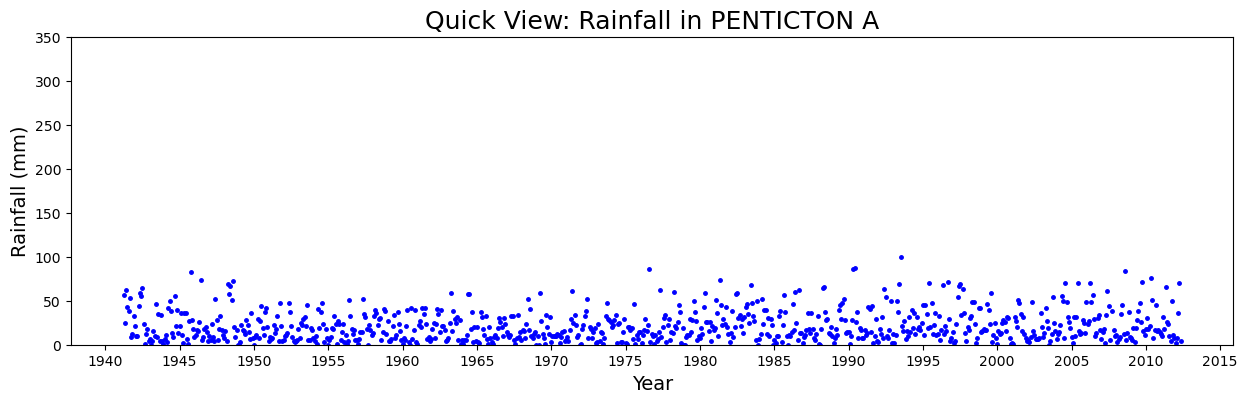

In [29]:
def graph_precip(dataframe):
  x = np.arange(912)
  fig = plt.figure(figsize=(15,4))
  ax = fig.add_subplot(111)
  ax.plot(dataframe['datetime'],dataframe['Total_Rain'],marker='.',markersize=5,color='b',linestyle='None')

  loc = mdates.YearLocator(5)
  ax.xaxis.set_major_locator(loc)
  fmt = mdates.DateFormatter('%Y')
  ax.xaxis.set_major_formatter(fmt)
  ax.set_ylim([0,350])

  plt.xlabel('Year',fontsize=14)
  plt.ylabel('Rainfall (mm)',fontsize=14)
  plt.title('Quick View: Rainfall in {}'.format(dataframe.iloc[0]['Station_Name']), fontsize=18)

  plt.show()

graph_precip(df_vancouver)
graph_precip(df_pg)
graph_precip(df_pencticton)


Results of whether to fill with

### Fill in empty values
Here we created another function which will automatically fill empty columns with the median values based on columns of interest.

In [30]:
def fill_empty(columns, dataframe):
    for column in columns:
        dataframe[column].fillna(dataframe[column].median(), inplace=True)
    return dataframe


columns_interest = ('Total_Rain', 'Mean_Temp')

working_data_vancouver = fill_empty(columns_interest, df_vancouver)
working_data_pg = fill_empty(columns_interest, df_pg)
working_data_pencticton = fill_empty(columns_interest, df_pencticton)


working_data_vancouver.isnull().sum()
working_data_pg.isnull().sum()
working_data_pencticton.isnull().sum()

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2237826079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column].fillna(dataframe[column].median(), inplace=True)
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2237826079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column].fillna(dataframe[column].median(), inplace=True)
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2237826079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Station_Name    0
Climate ID      0
lon             0
lat             0
Year            0
Month           0
Mean_Temp       0
Total_Rain      0
datetime        0
dtype: int64

Regraph to check if the values were done nicely

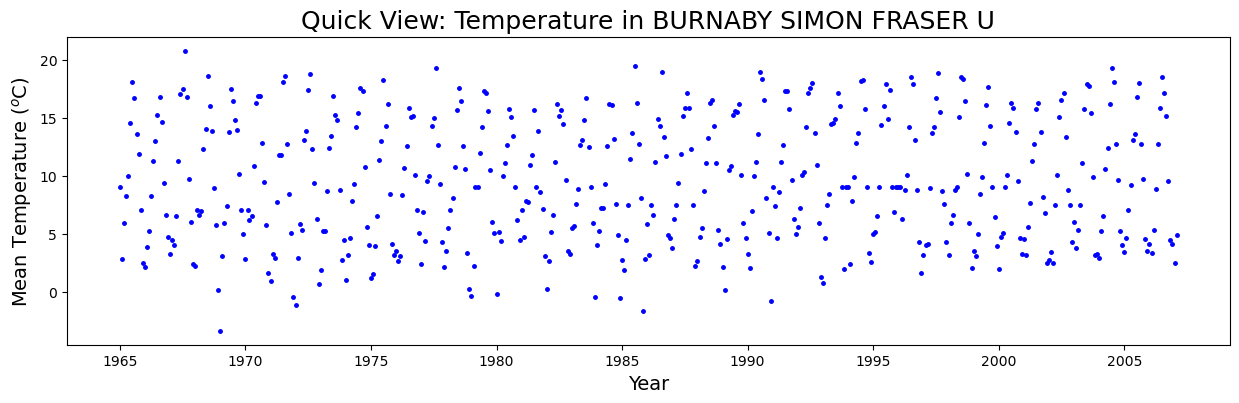

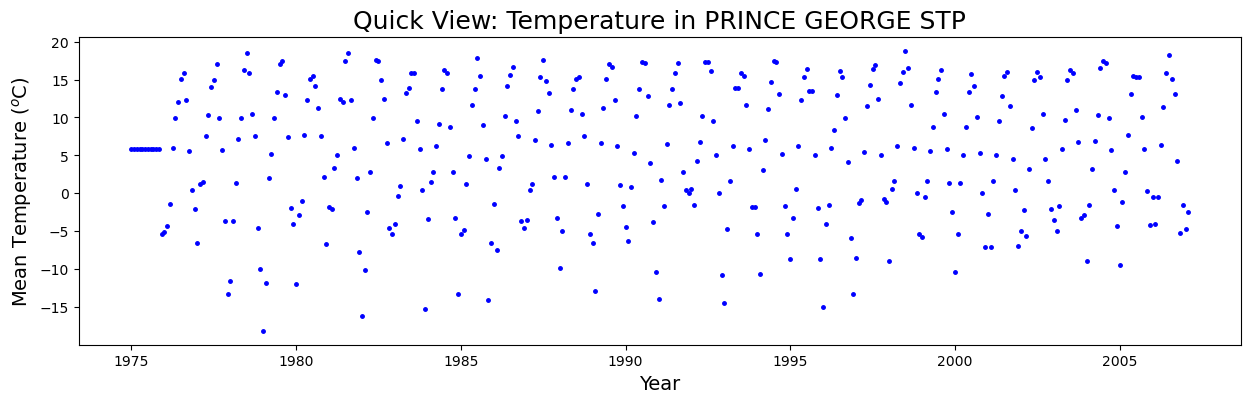

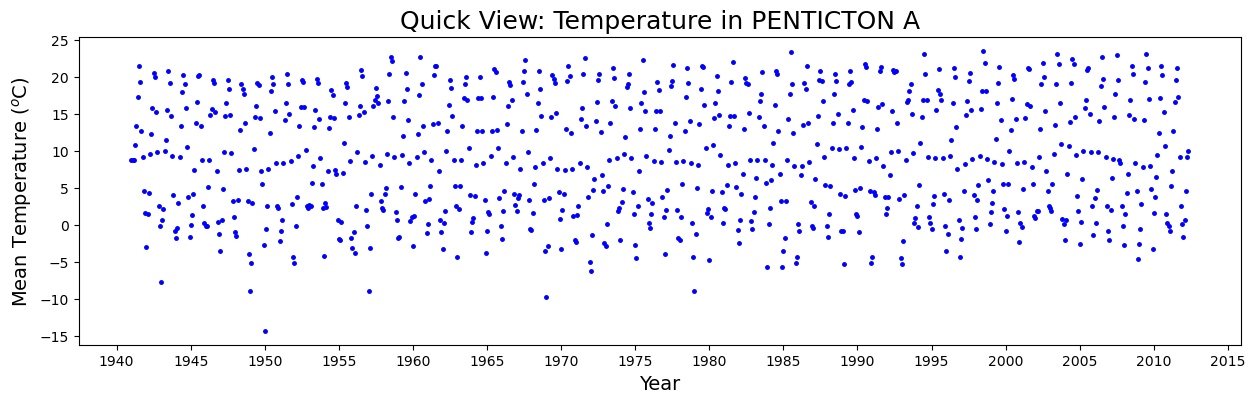

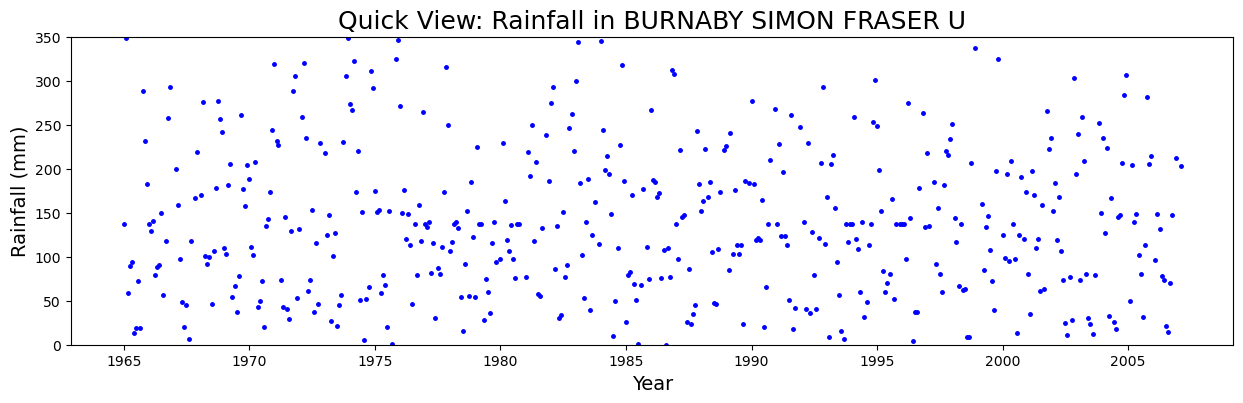

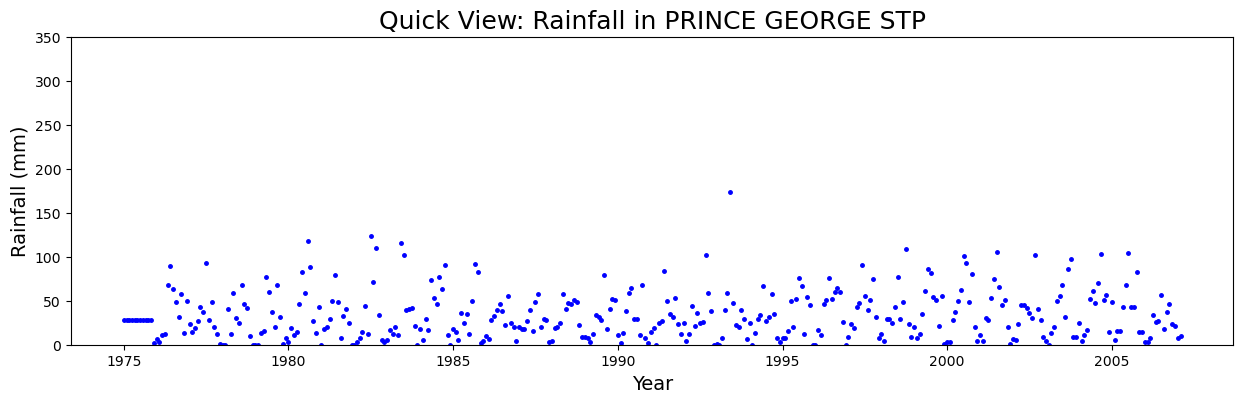

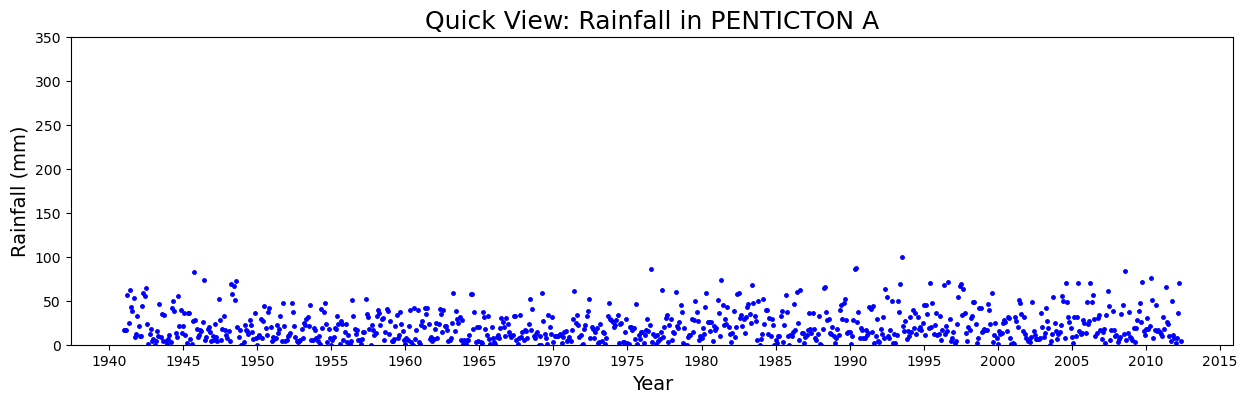

In [31]:
graph_temp(working_data_vancouver)
graph_temp(working_data_pg)
graph_temp(working_data_pencticton)

graph_precip(working_data_vancouver)
graph_precip(working_data_pg)
graph_precip(working_data_pencticton)

#Mann-Kendall Test
In this section we apply the Mann Kendall Test to check for significance in a trend overtime.




In [96]:
mk_data_vancouver = working_data_vancouver.set_index('datetime')
mann_k_test_van_temp = mk.original_test(mk_data_vancouver['Mean_Temp'])
print("Vancouver Temp: ", mann_k_test_van_temp)

mann_k_test_van_precip = mk.original_test(mk_data_vancouver['Total_Rain'])
print("Vancouver Precip: ",mann_k_test_van_precip)

mk_data_pg = working_data_pg.set_index('datetime')
mann_k_test_pg_temp = mk.original_test(mk_data_pg['Mean_Temp'])
print("Prince George Temp: ",mann_k_test_pg_temp)

mann_k_test_pg_precip = mk.original_test(mk_data_pg['Total_Rain'])
print("Prince George Precip: ",mann_k_test_pg_precip)

mk_data_penticton = working_data_pencticton.set_index('datetime')
mann_k_test_penticton_temp = mk.original_test(mk_data_vancouver['Mean_Temp'])
print("Penticton Temp: ",mann_k_test_penticton_temp)

mann_k_test_penticton_precip = mk.original_test(mk_data_vancouver['Total_Rain'])
print("Penticton Precip: ",mann_k_test_penticton_precip)

Vancouver Temp:  Mann_Kendall_Test(trend='no trend', h=False, p=0.4101976340409301, z=0.8235458867071435, Tau=0.024498101984111453, s=3130.0, var_s=14435622.666666666, slope=0.0012254901960784314, intercept=8.790563725490196)
Vancouver Precip:  Mann_Kendall_Test(trend='no trend', h=False, p=0.7847078849333489, z=0.27318906541991655, Tau=0.008132117559582045, s=1039.0, var_s=14436705.0, slope=0.007373271889400929, intercept=134.83824884792625)
Prince George Temp:  Mann_Kendall_Test(trend='no trend', h=False, p=0.8583526016185434, z=0.17847162727344942, Tau=0.0060964941793957336, s=453.0, var_s=6414141.0, slope=0.00035587188612099517, intercept=5.831494661921709)
Prince George Precip:  Mann_Kendall_Test(trend='no trend', h=False, p=0.09925460469040814, z=1.6484780823780232, Tau=0.05620079402462822, s=4176.0, var_s=6414260.666666667, slope=0.015901060070671377, intercept=25.43904593639576)
Penticton Temp:  Mann_Kendall_Test(trend='no trend', h=False, p=0.4101976340409301, z=0.823545886707

## Data Visualization
During the first step of data visualization, we can explore the data to find gaps, places where the data looks funky, and get a quick overview of the data. The following section displays the data accessed from earlier.

### Note on data availability
As seen on the three graphs above, there are different date ranges for our three sites. We will now subset our dataframes into the years we want (1977-2007) so Penticton and Vancouver stations match with the Prince Georga statation.

In [305]:
coast_data = working_data_vancouver.set_index(['datetime'])
clean_coast_data = coast_data.loc['1977-01-01':'2006-12-12']

clean_central_data = working_data_pg.query('Year >= 1977 & Year <= 2006')
clean_interior_data = working_data_pencticton.query('Year >= 1977 & Year <= 2006')


### Now we can explore our cleaned data


In [306]:
print(clean_coast_data.__len__())

360


In [307]:
months = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sep',
    10:'Oct',
    11:'Nov',
    12:'Dec'   
}
months.values()



dict_values(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Further Data Visualization and Analysis for each station.
Now that we have clean data for each one of our stations (Coastal, Central Interior, and Southern Interior), we can start graphing and looking at various different analyses of the data.

## Coastal Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

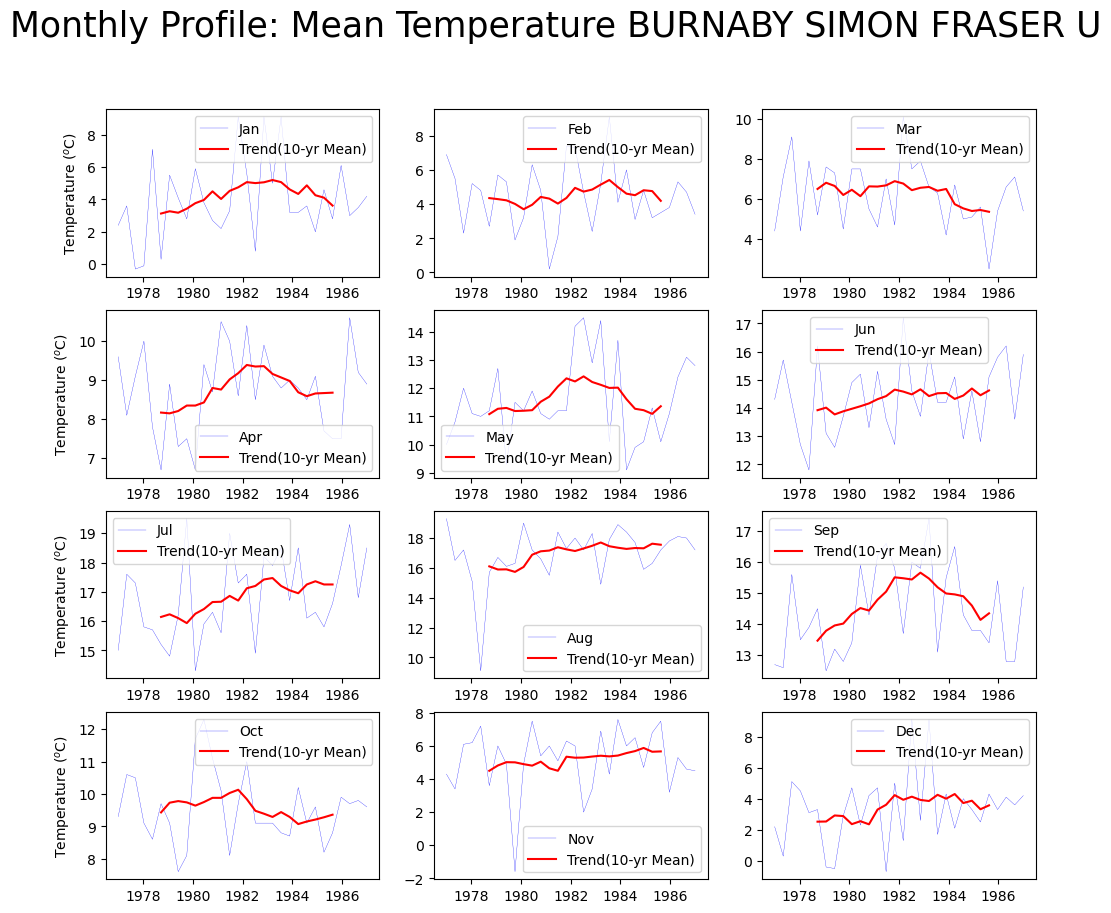

In [308]:
year_val = np.linspace(1977,1987, 30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_coast_data[clean_coast_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature {}'.format(clean_coast_data.iloc[0]['Station_Name']),fontsize=25)

    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

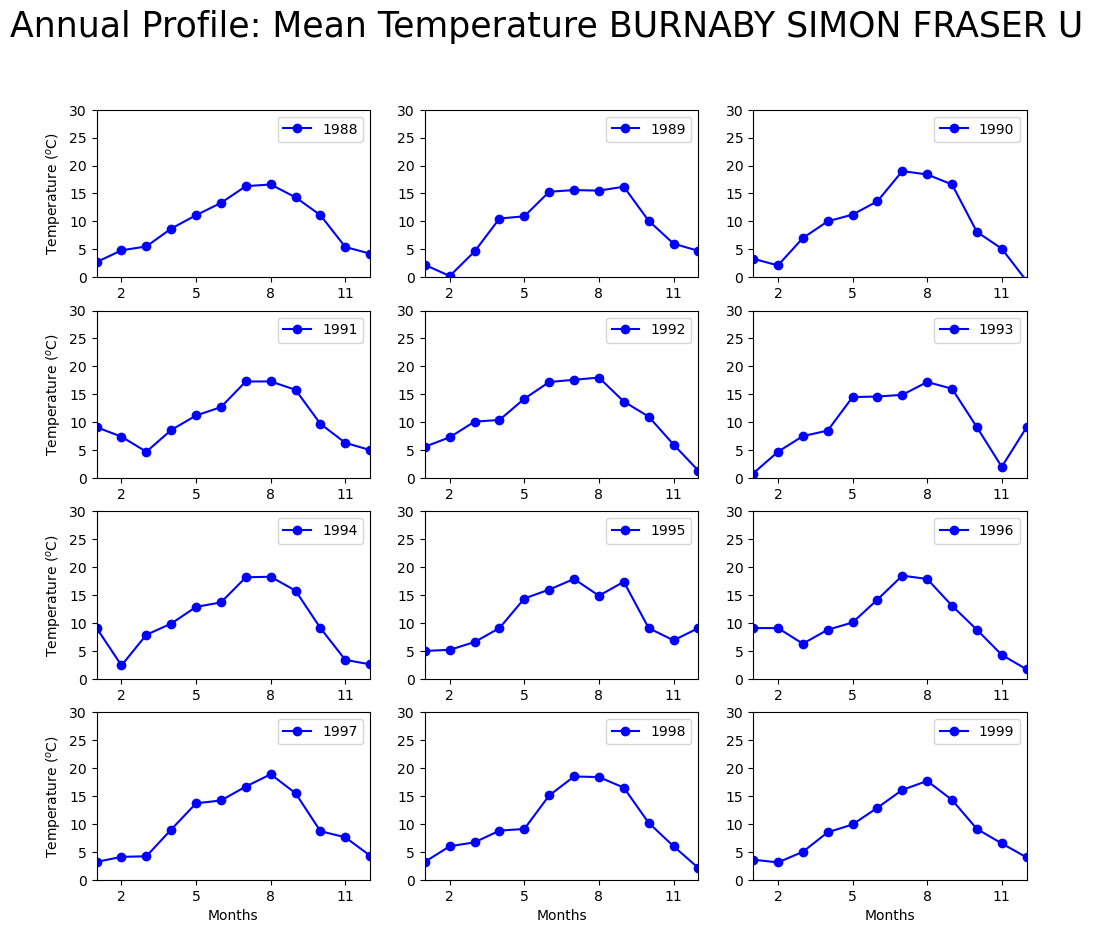

In [309]:
year = np.arange(1988,2000)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_coast_data[clean_coast_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature {}'.format(clean_coast_data.iloc[0]['Station_Name']), fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

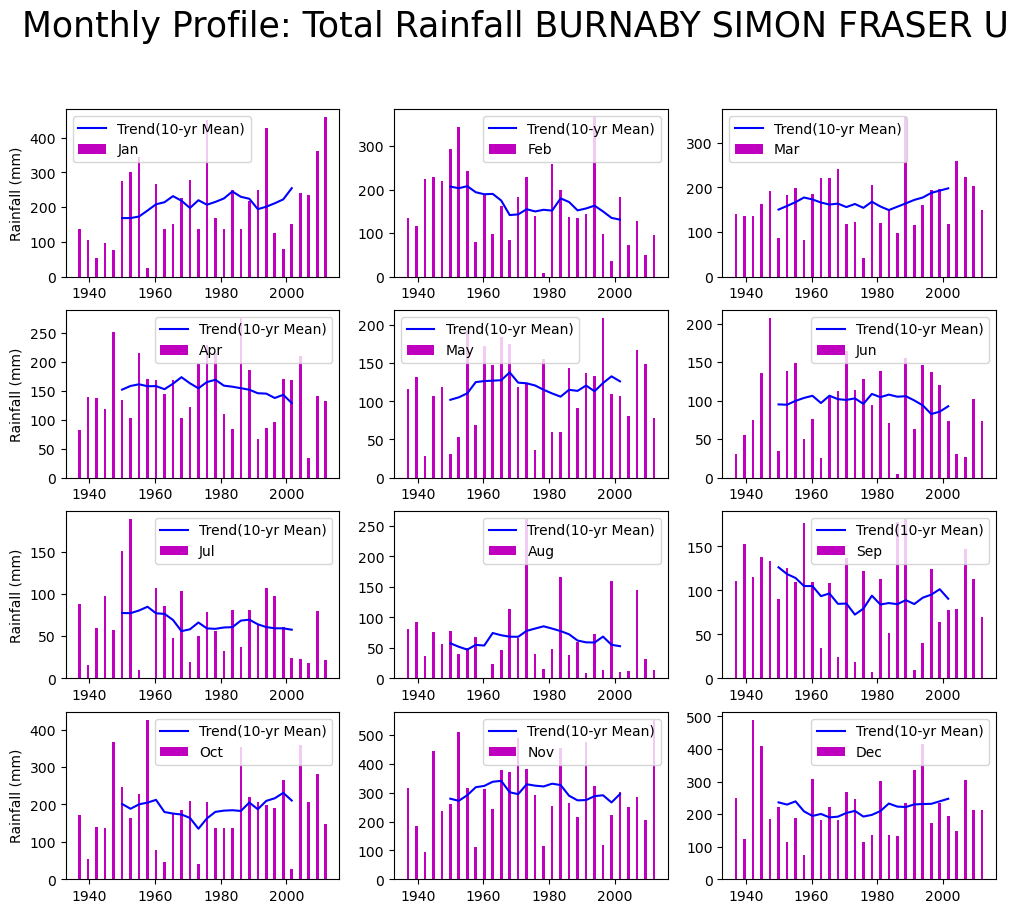

In [310]:
year_val = np.linspace(1937,2012,30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_coast_data[clean_coast_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall {}'.format(clean_coast_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

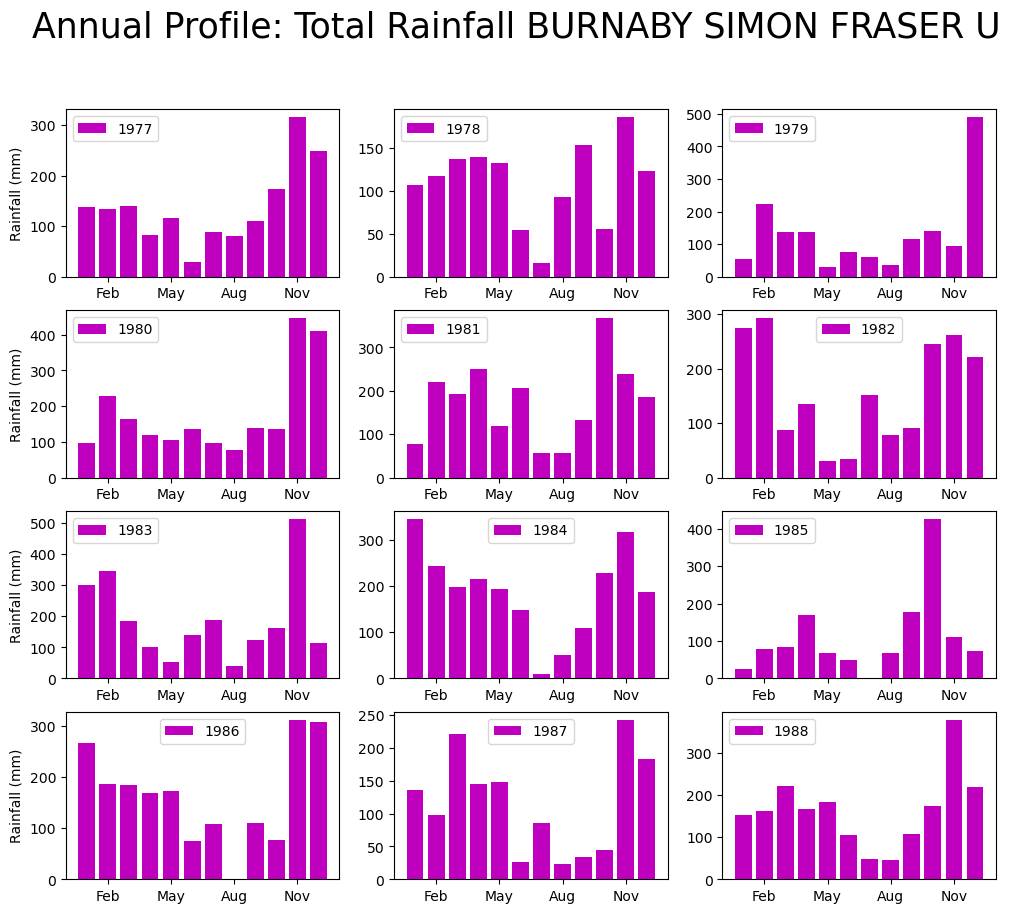

In [311]:
year = np.arange(1977,1989)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_coast_data[clean_coast_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall {}'.format(clean_coast_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [312]:
Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\617222211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)


#### Mean Monthly Temperature

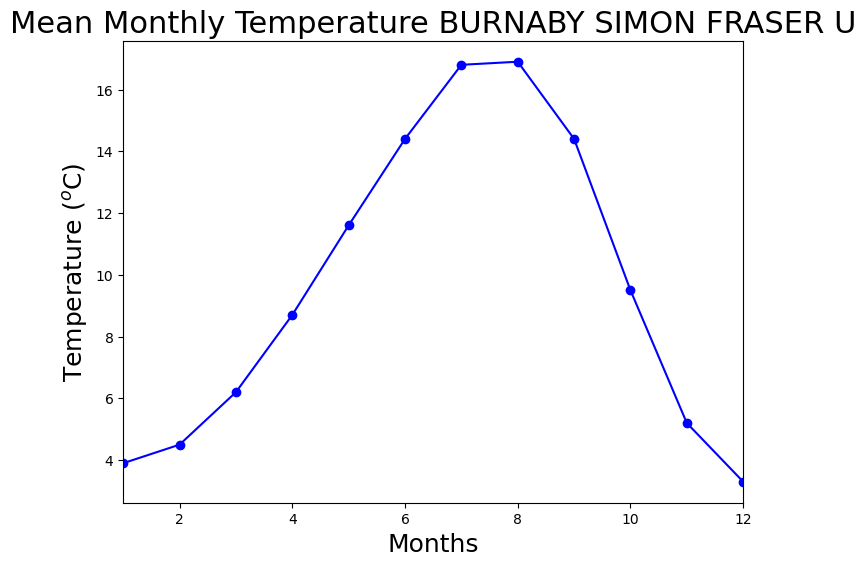

In [313]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature {}'.format(clean_coast_data.iloc[0]['Station_Name']), fontsize=22)

plt.show()

#### Mean Monthly Rainfall

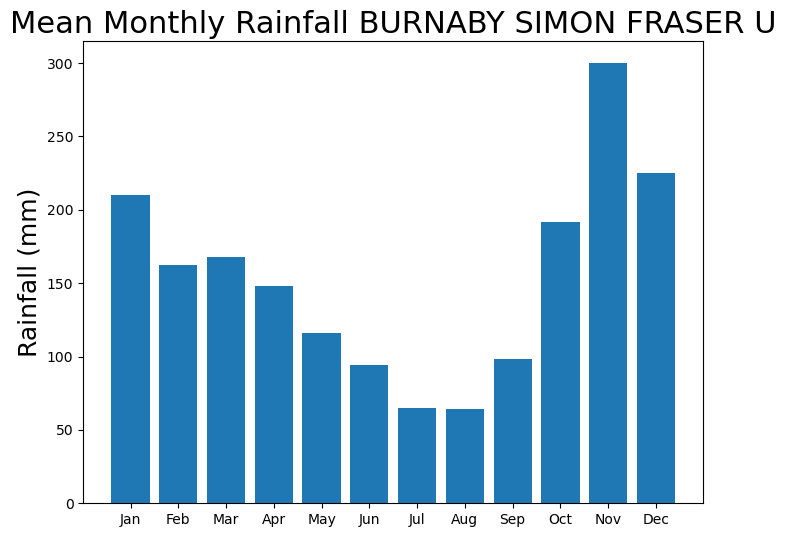

In [314]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall {}'.format(clean_coast_data.iloc[0]['Station_Name']), fontsize=22)
plt.show()

### Seasonal Means

In [315]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_coast_data['season'] = [month_num_2_season.get(i) for i in clean_coast_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_coast_data.groupby('season').mean(),1)
seasonal_val


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1821606433.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_coast_data['season'] = [month_num_2_season.get(i) for i in clean_coast_data.Month]
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1821606433.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_val = np.round(clean_coast_data.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1101158.0,-122.9,49.3,1991.5,5.0,3.9,199.3
JJA,1101158.0,-122.9,49.3,1991.5,7.0,16.0,74.4
MAM,1101158.0,-122.9,49.3,1991.5,4.0,8.8,144.0
SON,1101158.0,-122.9,49.3,1991.5,10.0,9.7,196.6


### Data Visualization 10 years

In [316]:
coastal_recent = clean_coast_data[clean_coast_data['Year'] >= 1995]
coastal_recent

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,season
datetime,,,,,,,,,
1995-01-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1995,1,5.0,248.6,DJF
1995-02-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1995,2,5.2,198.5,DJF
1995-03-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1995,3,6.6,152.2,MAM
1995-04-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1995,4,9.1,84.2,MAM
1995-05-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1995,5,14.4,60.0,MAM
...,...,...,...,...,...,...,...,...,...
2006-08-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,8,17.2,14.4,JJA
2006-09-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,9,15.2,69.8,SON
2006-10-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,10,9.6,147.7,SON


In [317]:
monthly_mean_recent = coastal_recent.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\4236380682.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = coastal_recent.groupby('Month').mean()


,Climate ID,lon,lat,Year,Mean_Temp,Total_Rain
Month,,,,,,
1,1101158.0,-122.92,49.28,2000.5,4.191667,244.141667
2,1101158.0,-122.92,49.28,2000.5,4.683333,137.158333
3,1101158.0,-122.92,49.28,2000.5,5.541667,185.858333
4,1101158.0,-122.92,49.28,2000.5,8.725000,136.933333
5,1101158.0,-122.92,49.28,2000.5,11.508333,122.150000
6,1101158.0,-122.92,49.28,2000.5,14.700000,83.425000
7,1101158.0,-122.92,49.28,2000.5,17.408333,57.883333
8,1101158.0,-122.92,49.28,2000.5,17.358333,60.933333
9,1101158.0,-122.92,49.28,2000.5,14.500000,94.466667


#### Mean Temperature Change

In [318]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


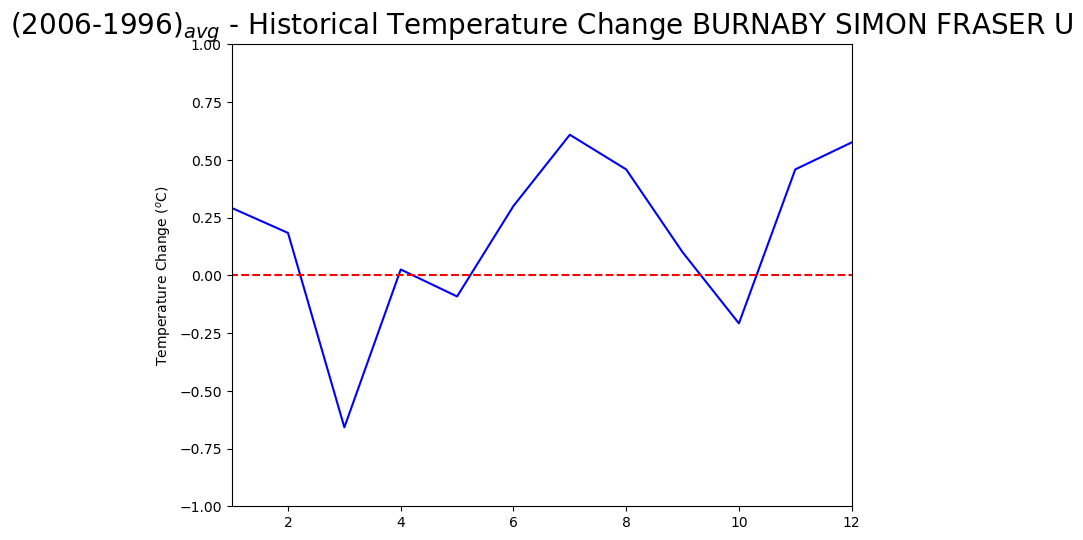

In [319]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-1,1)
ax.plot([0,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Temperature Change BURNABY SIMON FRASER U', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [320]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

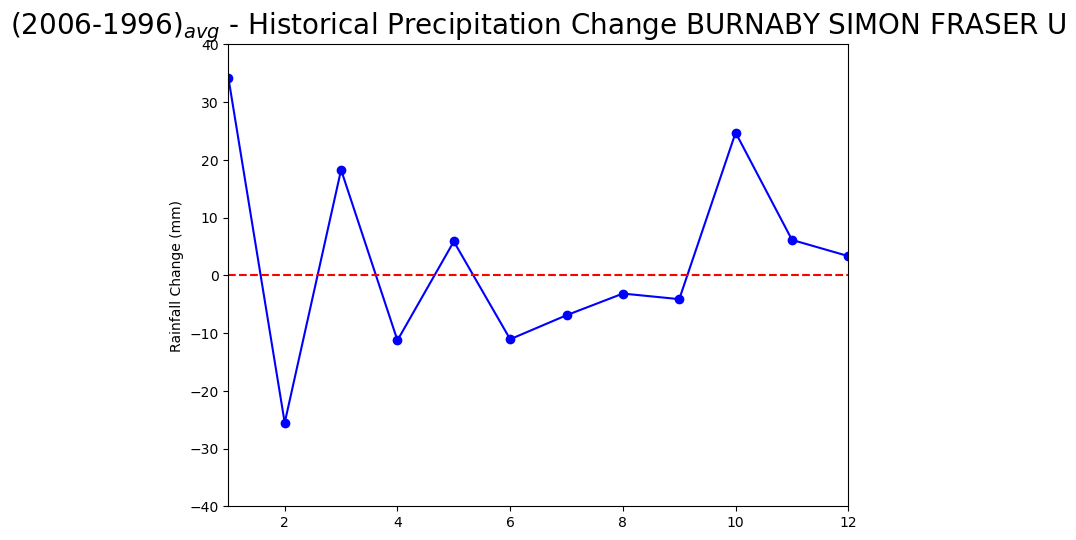

In [321]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-40,40)
ax.plot([1,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Precipitation Change BURNABY SIMON FRASER U', fontsize=20)
plt.show()

#### Seasonal Means

In [322]:
seasonal_recent = np.round(coastal_recent.groupby('season').mean(),1)
seasonal_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\531591284.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_recent = np.round(coastal_recent.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1101158.0,-122.9,49.3,2000.5,5.0,4.2,203.3
JJA,1101158.0,-122.9,49.3,2000.5,7.0,16.5,67.4
MAM,1101158.0,-122.9,49.3,2000.5,4.0,8.6,148.3
SON,1101158.0,-122.9,49.3,2000.5,10.0,9.8,205.5


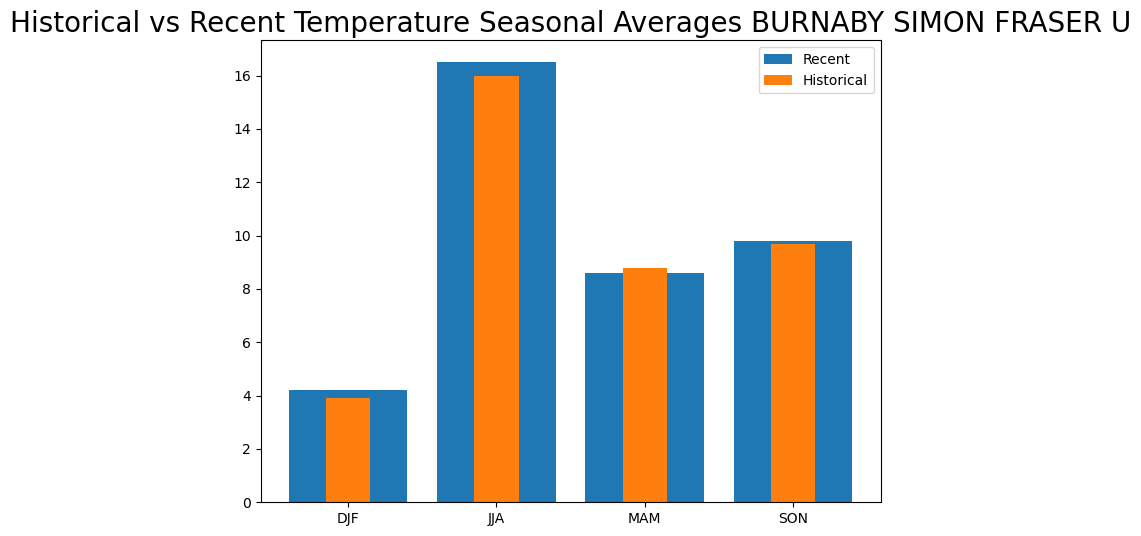

In [323]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages BURNABY SIMON FRASER U', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [324]:
coastal_30 = clean_coast_data[clean_coast_data['Year'] >= 1976]
coastal_30

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,season
datetime,,,,,,,,,
1977-01-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1977,1,2.4,136.9,DJF
1977-02-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1977,2,6.9,134.3,DJF
1977-03-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1977,3,4.4,140.0,MAM
1977-04-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1977,4,9.6,81.7,MAM
1977-05-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,1977,5,10.0,115.7,MAM
...,...,...,...,...,...,...,...,...,...
2006-08-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,8,17.2,14.4,JJA
2006-09-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,9,15.2,69.8,SON
2006-10-01,BURNABY SIMON FRASER U,1101158,-122.92,49.28,2006,10,9.6,147.7,SON


#### Mean Temperature Change

In [325]:
df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1803563369.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)


9.63

In [326]:
Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\914197677.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


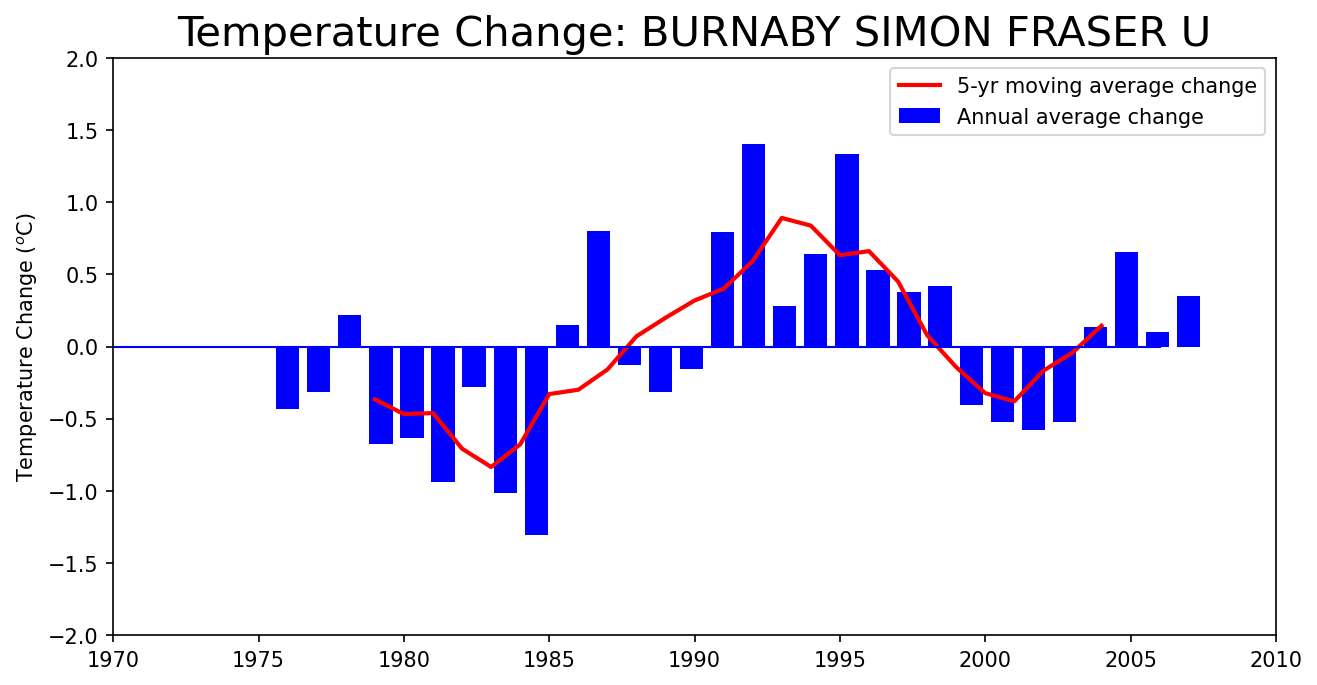

In [327]:
year_val = np.linspace(1976,2007,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1970,2010])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-2,2])


plt.title('Temperature Change: {}'.format(clean_coast_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [328]:
df_30yrs_Total_Rain = np.round(clean_coast_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\4199653423.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_coast_data.groupby('Year').mean().mean().Total_Rain,2)


153.59

In [329]:
Rdiff = clean_coast_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3090641514.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_coast_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


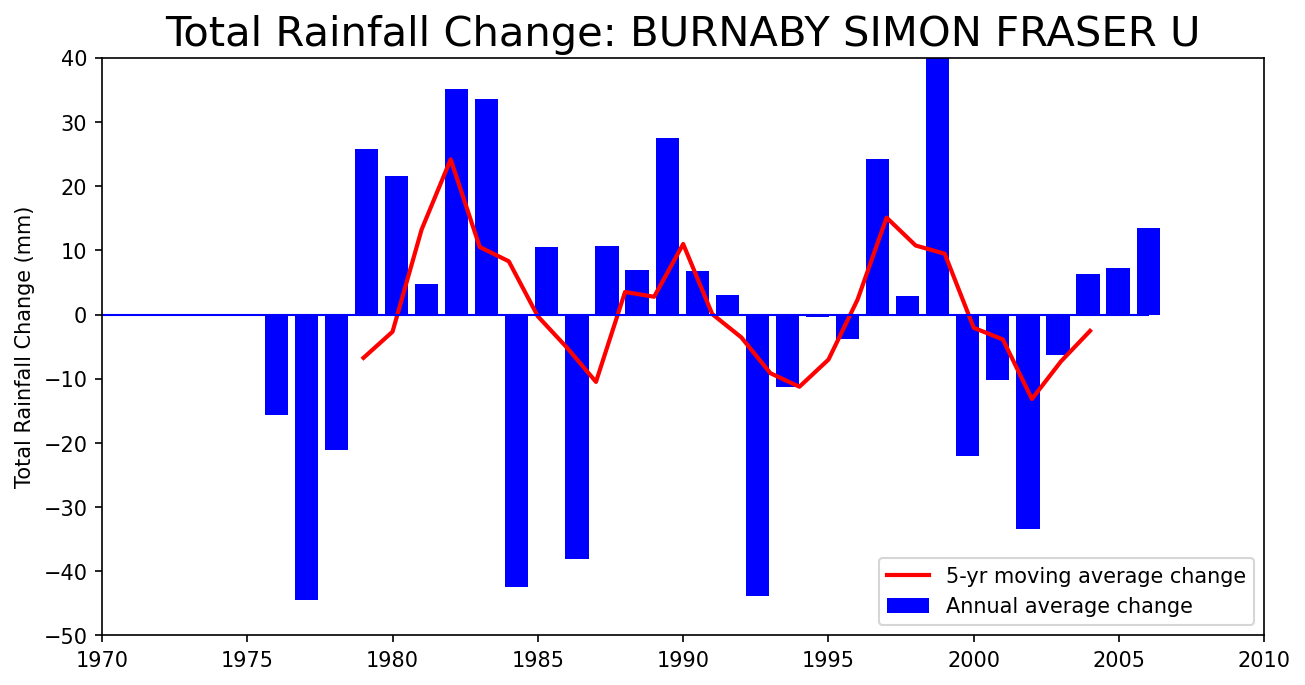

In [330]:
year_val = np.linspace(1976,2006,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1970,2010])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-50,40])


plt.title('Total Rainfall Change: {}'.format(clean_coast_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

## Central Interior Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

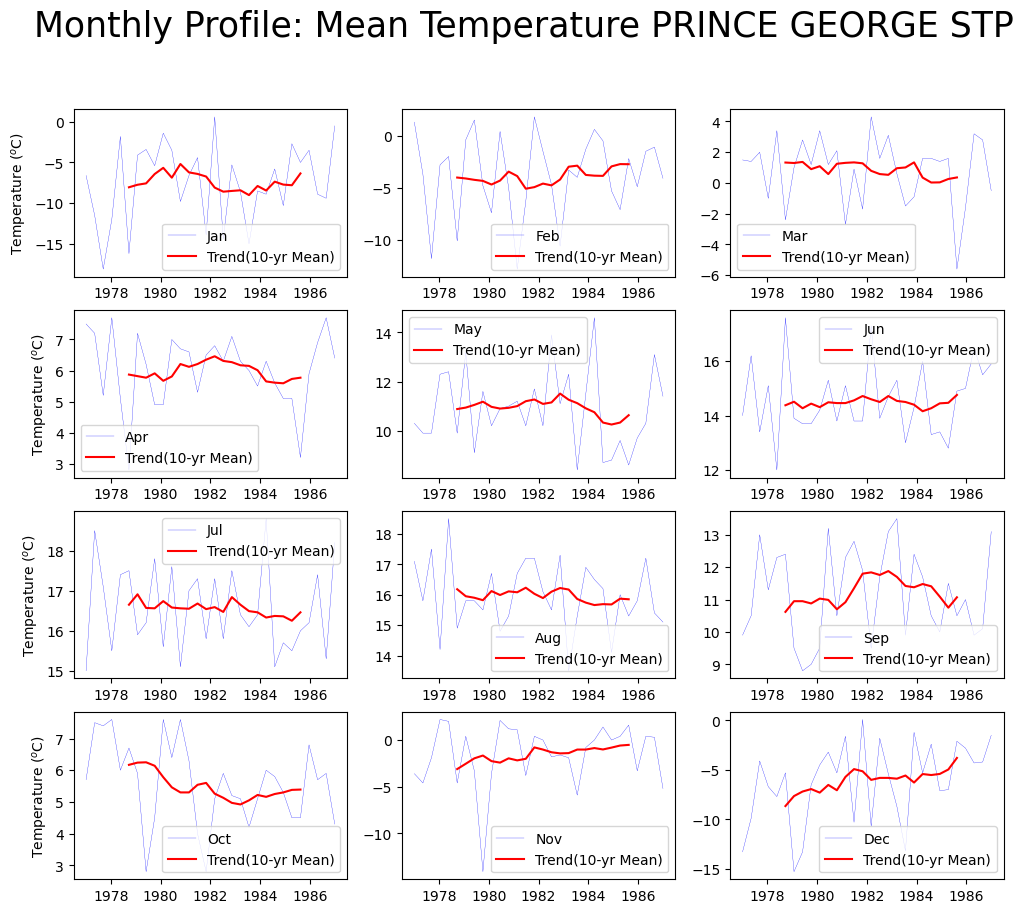

In [331]:
year_val = np.linspace(1977,1987, 30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_central_data[clean_central_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature {}'.format(clean_central_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

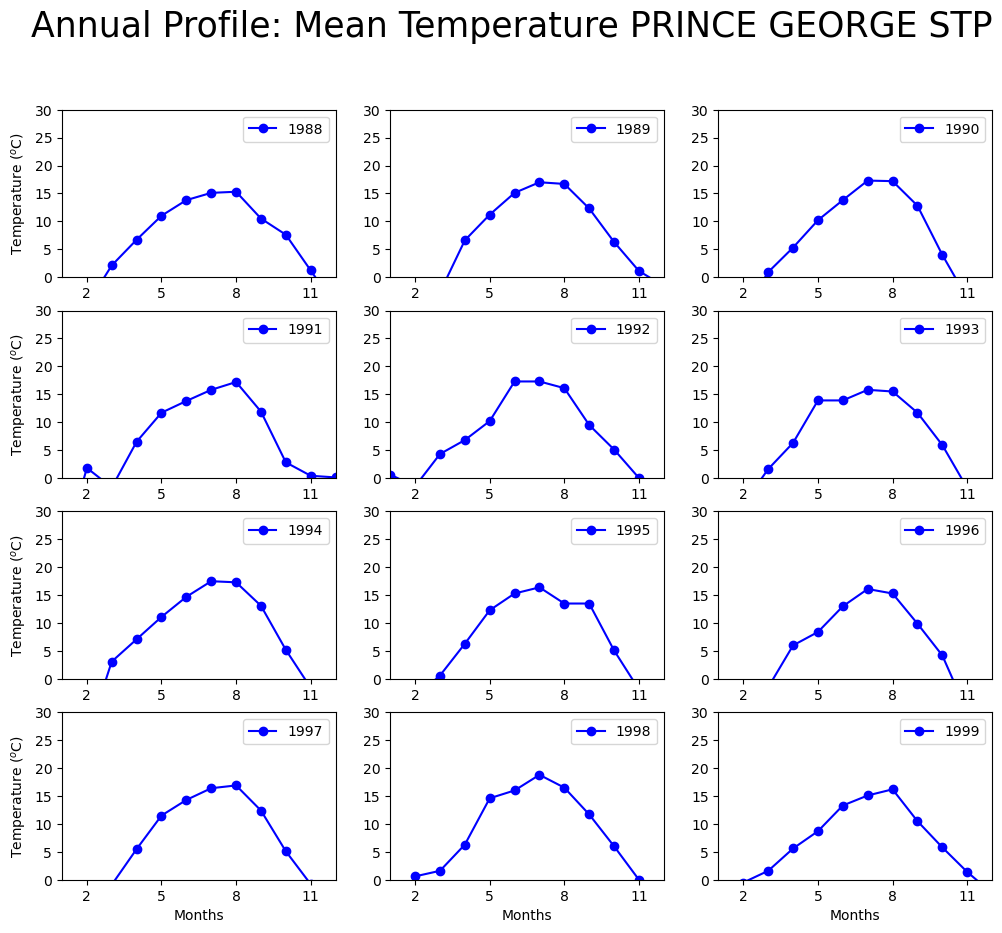

In [332]:
year = np.arange(1988,2000)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_central_data[clean_central_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature {}'.format(clean_central_data.iloc[0]['Station_Name']), fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

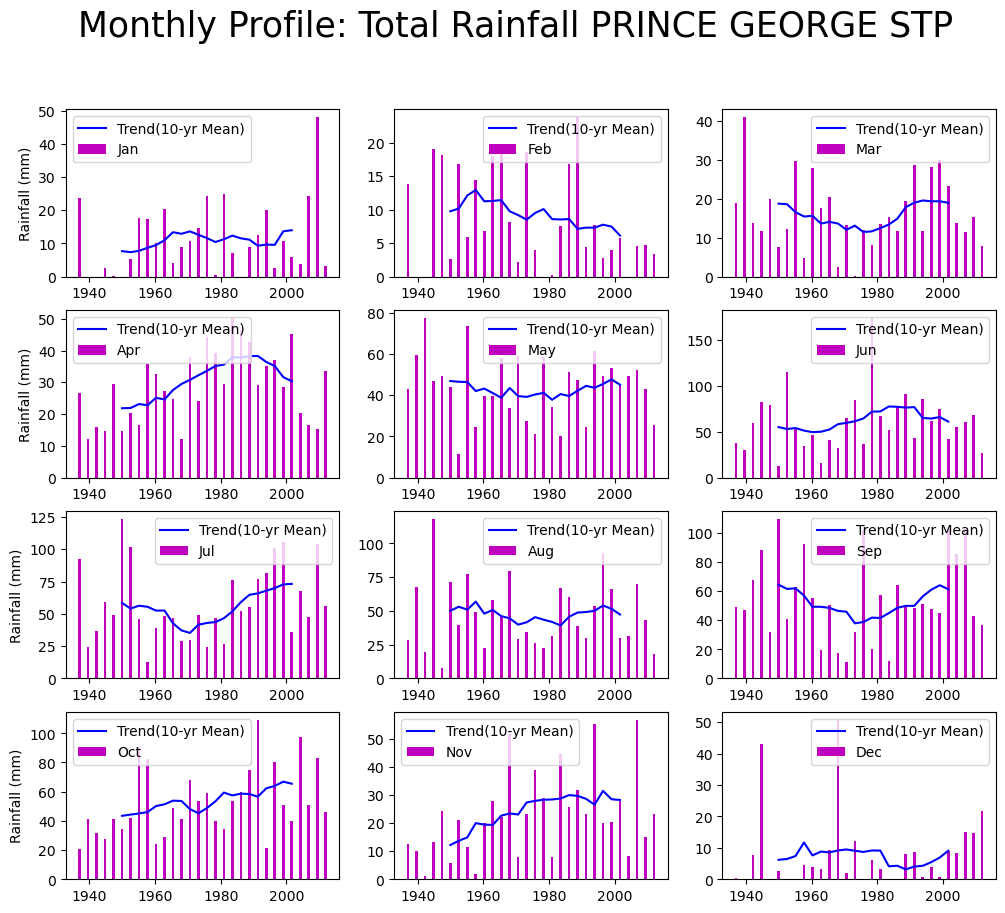

In [333]:
year_val = np.linspace(1937,2012,30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_central_data[clean_central_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall {}'.format(clean_central_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

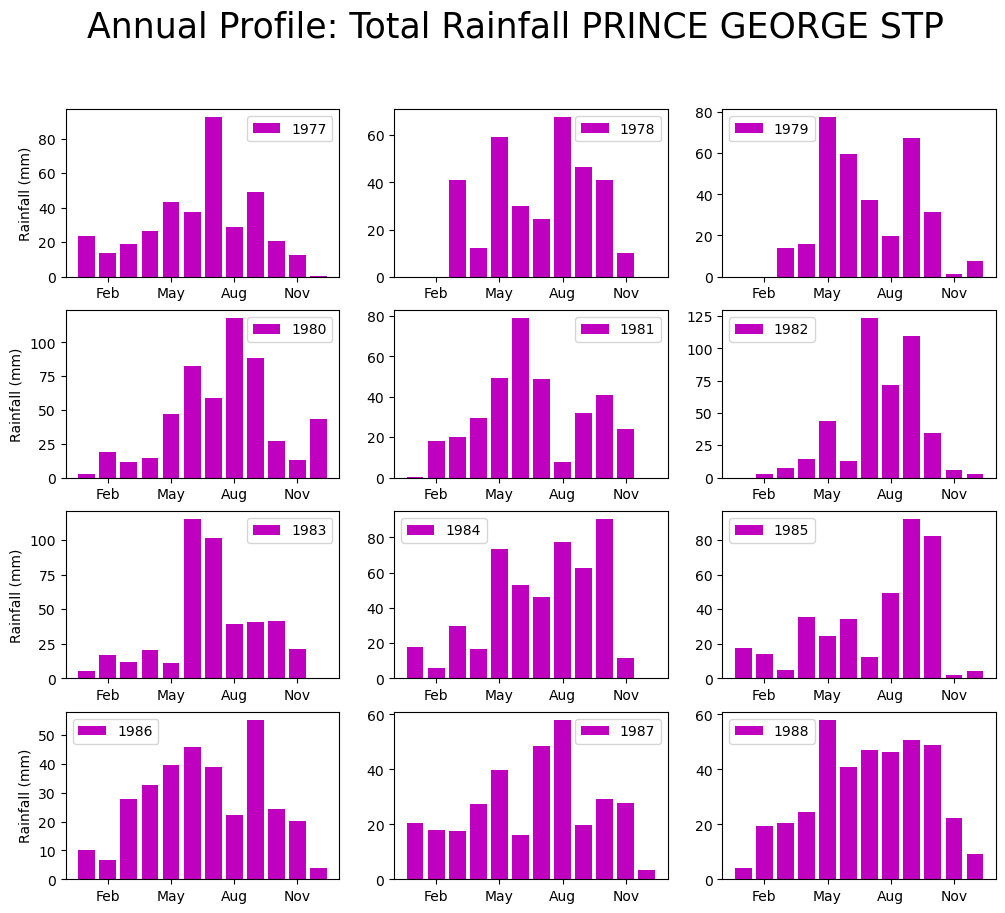

In [334]:
year = np.arange(1977,1989)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_central_data[clean_central_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall {}'.format(clean_central_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [335]:
Monthly_Mean = np.round(clean_central_data.groupby('Month').mean(),1)

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1770475638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Monthly_Mean = np.round(clean_central_data.groupby('Month').mean(),1)


#### Mean Monthly Temperature

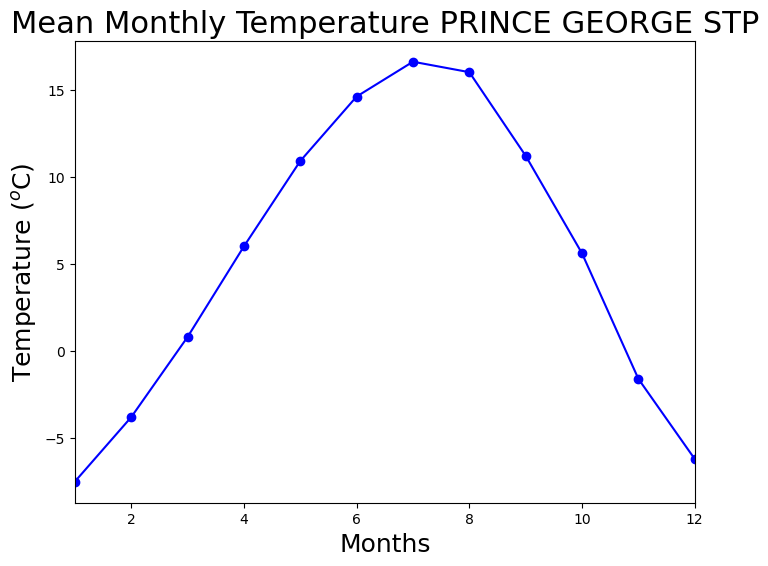

In [336]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature {}'.format(clean_central_data.iloc[0]['Station_Name']), fontsize=22)

plt.show()

#### Mean Monthly Rainfall

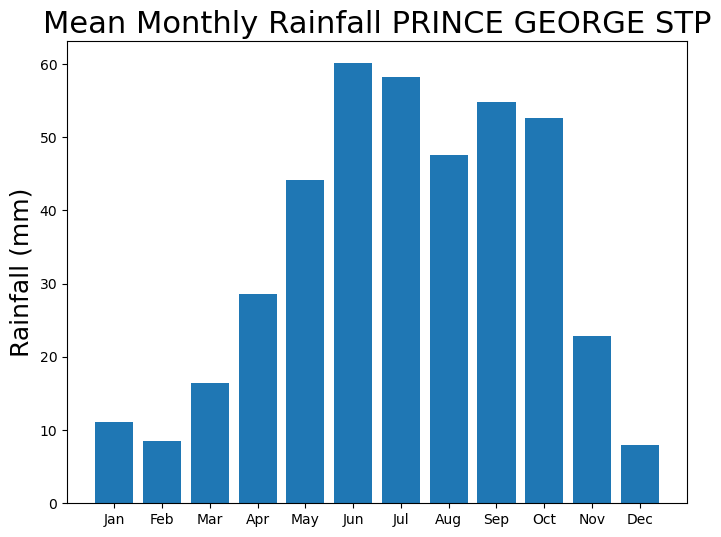

In [337]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall {}'.format(clean_central_data.iloc[0]['Station_Name']), fontsize=22)
plt.show()

### Seasonal Means

In [338]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_central_data['season'] = [month_num_2_season.get(i) for i in clean_central_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_central_data.groupby('season').mean(),1)
seasonal_val


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2139407118.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_central_data['season'] = [month_num_2_season.get(i) for i in clean_central_data.Month]
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2139407118.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_val = np.round(clean_central_data.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1096468.0,-122.8,53.9,1991.5,5.0,-5.8,9.2
JJA,1096468.0,-122.8,53.9,1991.5,7.0,15.7,55.3
MAM,1096468.0,-122.8,53.9,1991.5,4.0,5.9,29.7
SON,1096468.0,-122.8,53.9,1991.5,10.0,5.1,43.4


### Data Visualization 10 years

In [339]:
central_recent = clean_central_data[clean_central_data['Year'] >= 1995]
central_recent

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,datetime,season
240,PRINCE GEORGE STP,1096468,-122.77,53.88,1995,1,-8.6,7.2,1995-01-01,DJF
241,PRINCE GEORGE STP,1096468,-122.77,53.88,1995,2,-3.3,7.6,1995-02-01,DJF
242,PRINCE GEORGE STP,1096468,-122.77,53.88,1995,3,0.6,15.4,1995-03-01,MAM
243,PRINCE GEORGE STP,1096468,-122.77,53.88,1995,4,6.3,50.2,1995-04-01,MAM
244,PRINCE GEORGE STP,1096468,-122.77,53.88,1995,5,12.3,20.4,1995-05-01,MAM
...,...,...,...,...,...,...,...,...,...,...
379,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,8,15.1,18.1,2006-08-01,JJA
380,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,9,13.1,36.9,2006-09-01,SON
381,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,10,4.3,45.8,2006-10-01,SON
382,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,11,-5.2,23.1,2006-11-01,SON


In [340]:
monthly_mean_recent = central_recent.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3062484155.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = central_recent.groupby('Month').mean()


,Climate ID,lon,lat,Year,Mean_Temp,Total_Rain
Month,,,,,,
1,1096468.0,-122.77,53.88,2000.5,-7.258333,12.250000
2,1096468.0,-122.77,53.88,2000.5,-2.891667,7.150000
3,1096468.0,-122.77,53.88,2000.5,0.225000,18.050000
4,1096468.0,-122.77,53.88,2000.5,5.833333,33.325000
5,1096468.0,-122.77,53.88,2000.5,10.583333,43.541667
6,1096468.0,-122.77,53.88,2000.5,14.658333,61.491667
7,1096468.0,-122.77,53.88,2000.5,16.425000,71.650000
8,1096468.0,-122.77,53.88,2000.5,15.608333,50.025000
9,1096468.0,-122.77,53.88,2000.5,11.175000,57.450000


#### Mean Temperature Change

In [341]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


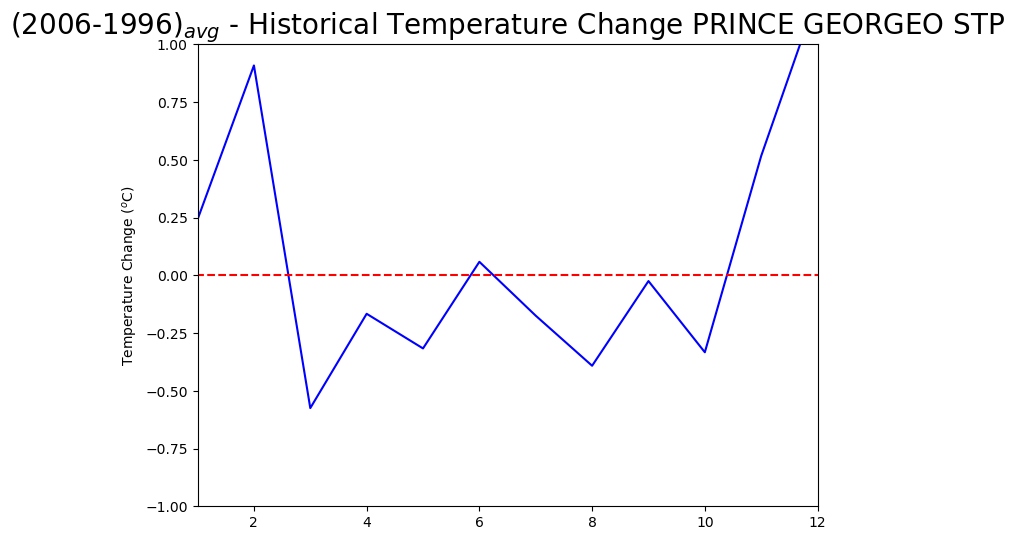

In [342]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-1,1)
ax.plot([0,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Temperature Change PRINCE GEORGEO STP', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [343]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

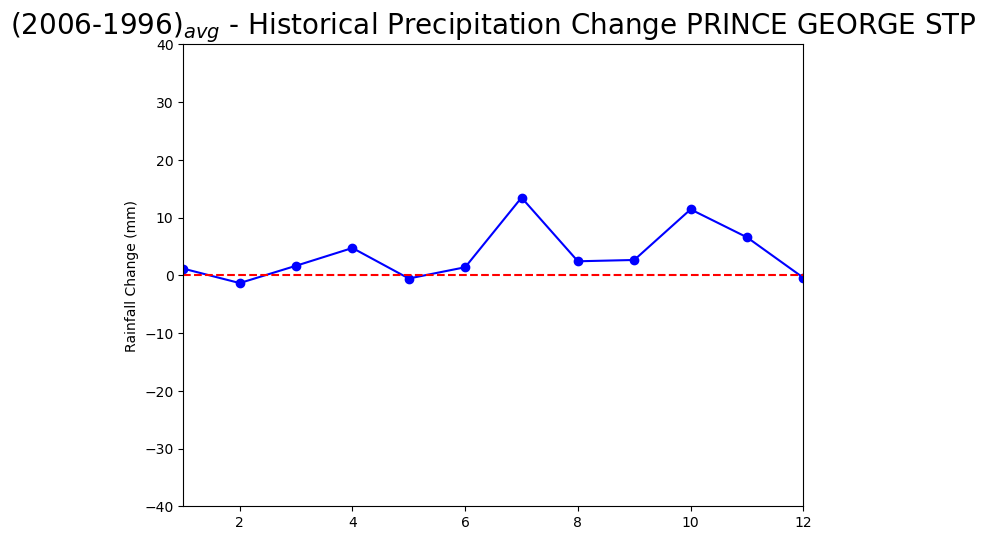

In [344]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-40,40)
ax.plot([1,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Precipitation Change PRINCE GEORGE STP', fontsize=20)
plt.show()

#### Seasonal Means

In [345]:
seasonal_recent = np.round(central_recent.groupby('season').mean(),1)
seasonal_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\180453069.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_recent = np.round(central_recent.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1096468.0,-122.8,53.9,2000.5,5.0,-5.0,9.0
JJA,1096468.0,-122.8,53.9,2000.5,7.0,15.6,61.1
MAM,1096468.0,-122.8,53.9,2000.5,4.0,5.5,31.6
SON,1096468.0,-122.8,53.9,2000.5,10.0,5.1,50.3


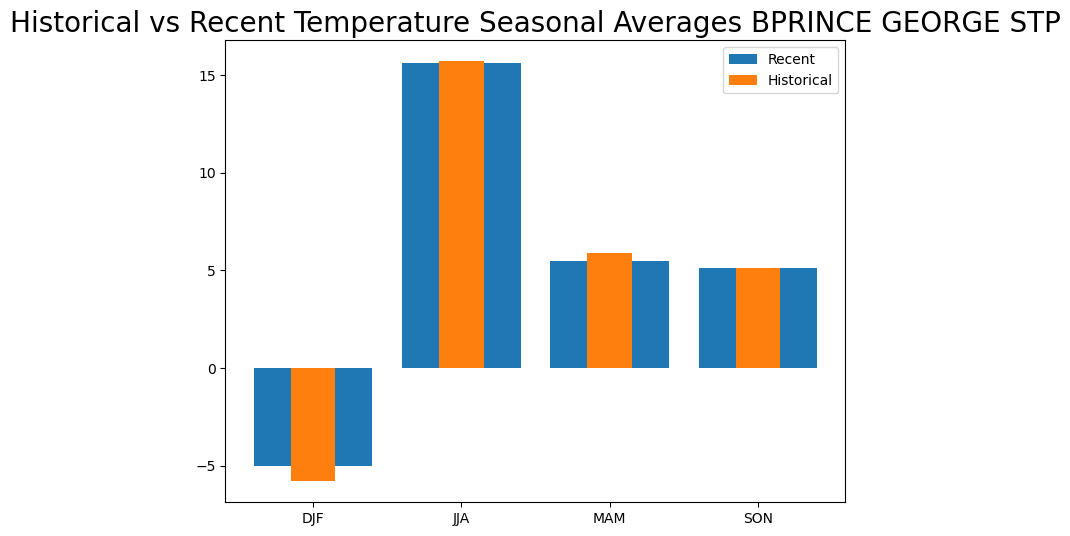

In [346]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages BPRINCE GEORGE STP', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [347]:
central_30 = clean_central_data[clean_central_data['Year'] >= 1976]
central_30

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,datetime,season
24,PRINCE GEORGE STP,1096468,-122.77,53.88,1977,1,-6.6,23.6,1977-01-01,DJF
25,PRINCE GEORGE STP,1096468,-122.77,53.88,1977,2,1.3,13.9,1977-02-01,DJF
26,PRINCE GEORGE STP,1096468,-122.77,53.88,1977,3,1.5,18.9,1977-03-01,MAM
27,PRINCE GEORGE STP,1096468,-122.77,53.88,1977,4,7.5,26.7,1977-04-01,MAM
28,PRINCE GEORGE STP,1096468,-122.77,53.88,1977,5,10.3,43.2,1977-05-01,MAM
...,...,...,...,...,...,...,...,...,...,...
379,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,8,15.1,18.1,2006-08-01,JJA
380,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,9,13.1,36.9,2006-09-01,SON
381,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,10,4.3,45.8,2006-10-01,SON
382,PRINCE GEORGE STP,1096468,-122.77,53.88,2006,11,-5.2,23.1,2006-11-01,SON


#### Mean Temperature Change

In [348]:
df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1803563369.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(coastal_30.groupby('Year').mean().mean().Mean_Temp,2)


9.63

In [349]:
Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\914197677.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_coast_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


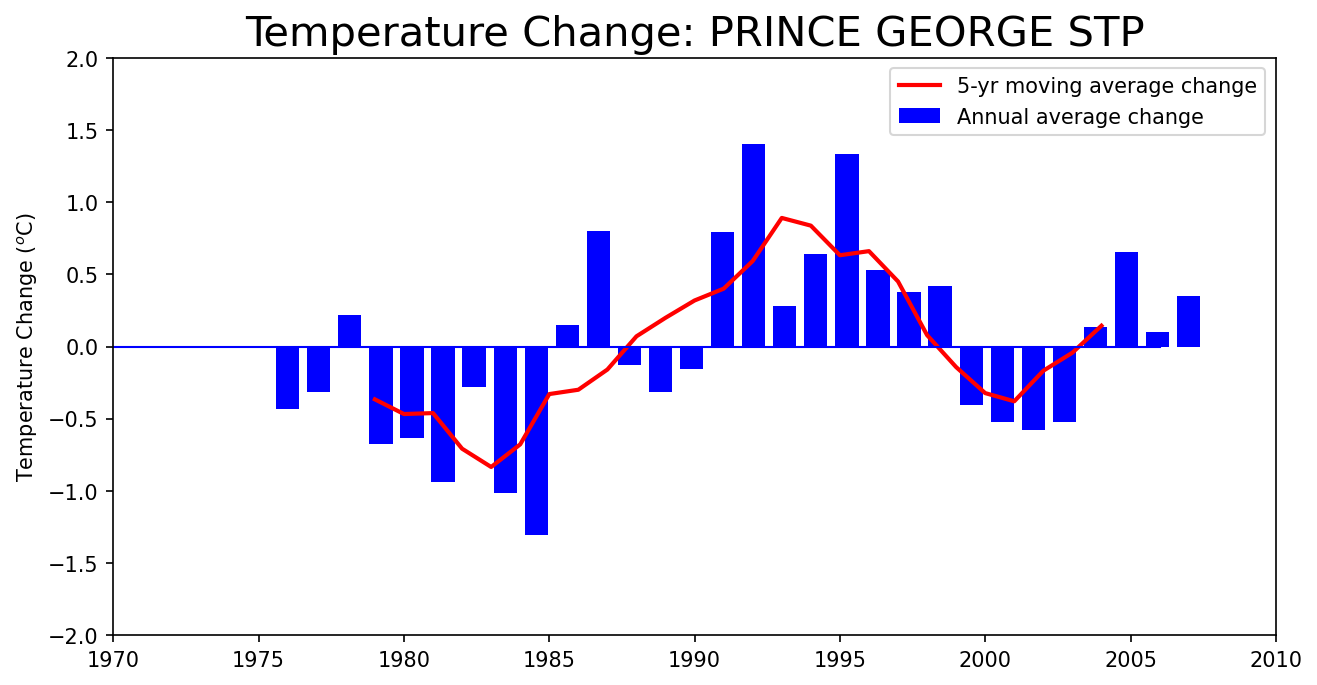

In [350]:
year_val = np.linspace(1976,2007,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1970,2010])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-2,2])


plt.title('Temperature Change: {}'.format(clean_central_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [351]:
df_30yrs_Total_Rain = np.round(clean_central_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1153513781.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_central_data.groupby('Year').mean().mean().Total_Rain,2)


34.38

In [352]:
Rdiff = clean_central_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3898913928.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_central_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


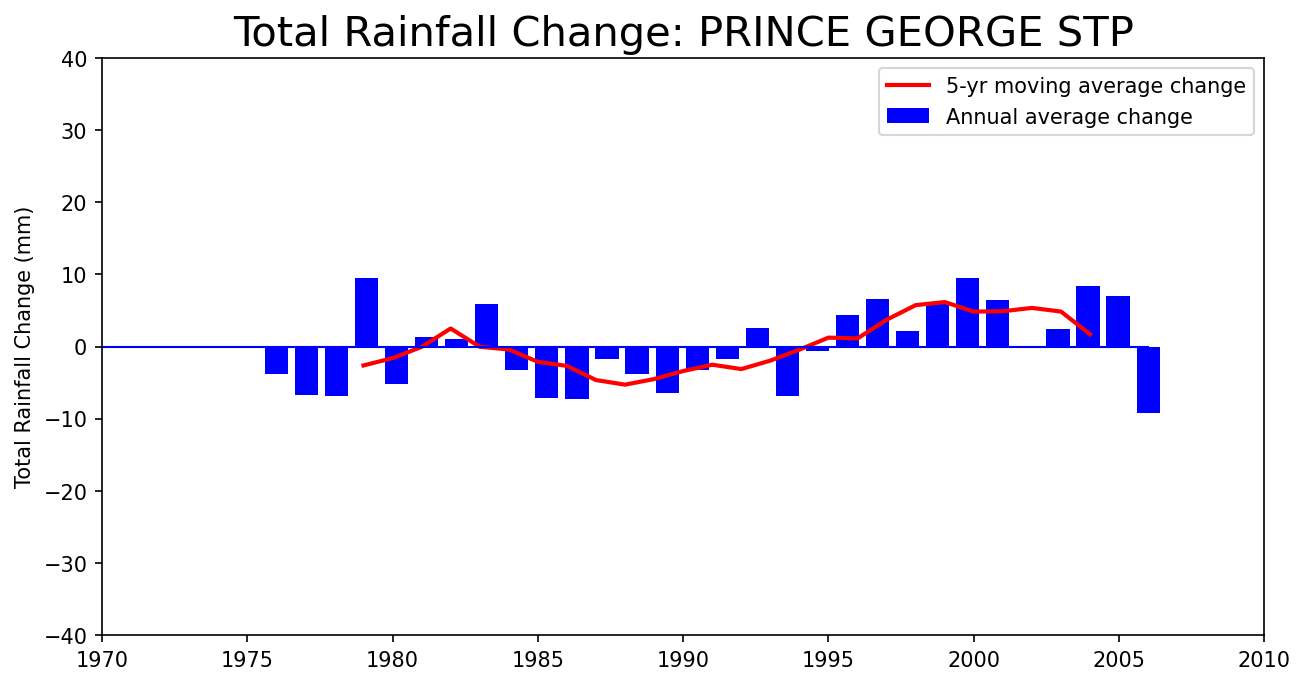

In [353]:
year_val = np.linspace(1976,2006,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1970,2010])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-40,40])


plt.title('Total Rainfall Change: {}'.format(clean_central_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

## Southern Interior Analysis

### Monthly Mean Temperature Profile
This graph provides the results of the monthly means for temperature over a 10 year mean.

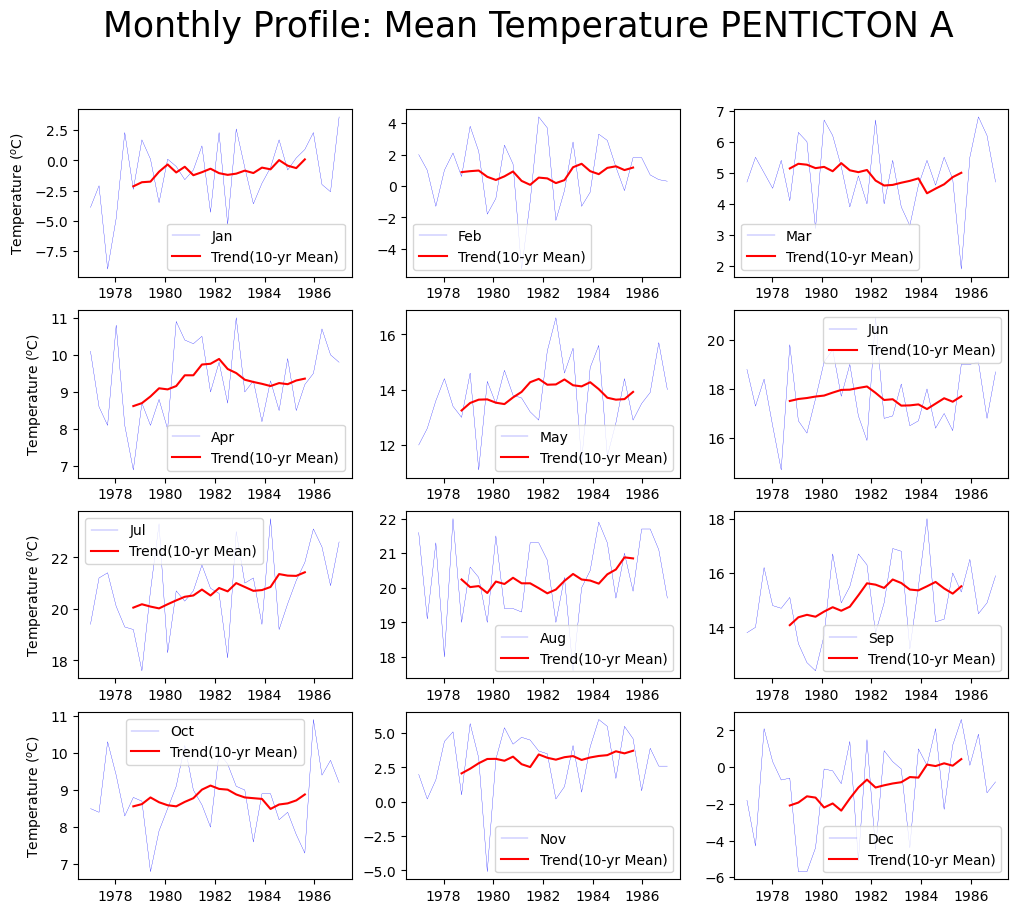

In [354]:
year_val = np.linspace(1977,1987, 30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_interior_data[clean_interior_data['Month'] == i+1 ]
    ax.plot(year_val, monthly_data.Mean_Temp, label=months.get(i+1), color='b', linewidth=0.2)
    window_10yrs = monthly_data['Mean_Temp'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='r',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')


fig.suptitle('Monthly Profile: Mean Temperature {}'.format(clean_interior_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()


### Yearly Mean Temperature Profile
This graph provides the results of the year means for temperature over 10 years.

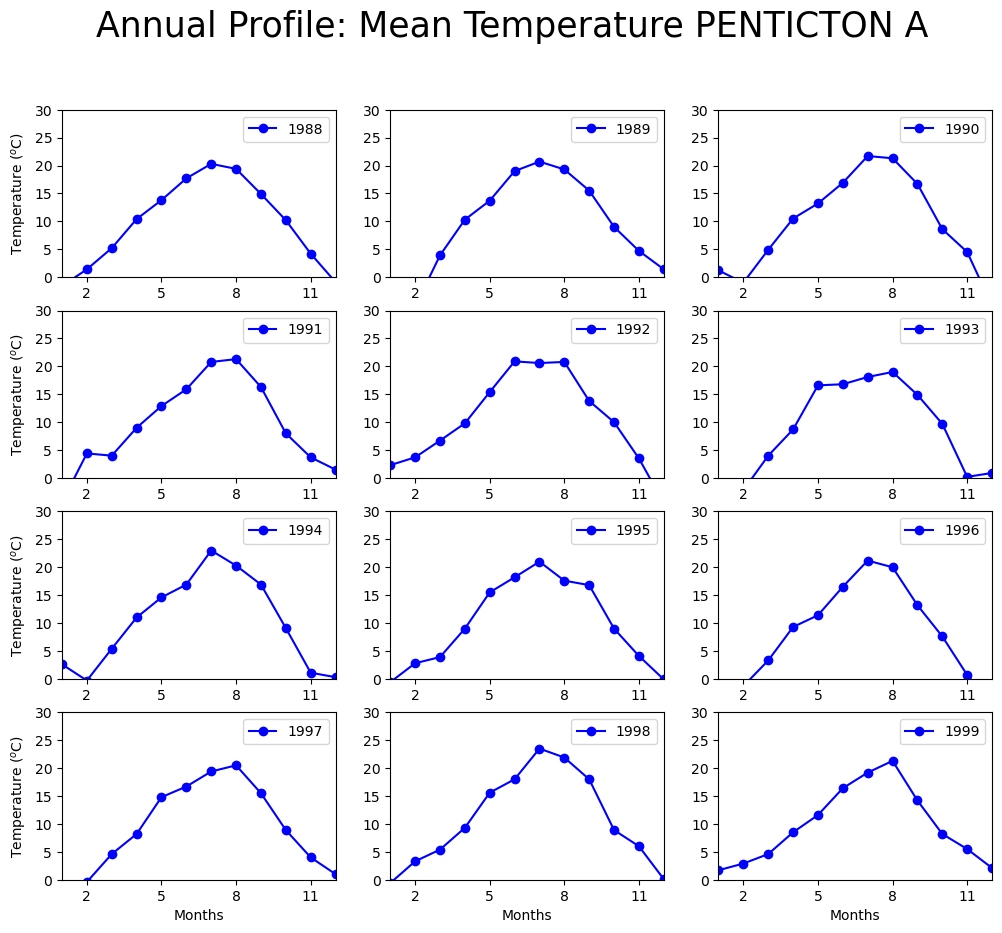

In [355]:
year = np.arange(1988,2000)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_interior_data[clean_interior_data['Year']==year[i]]
    ax.plot(yearly_data.Month, yearly_data.Mean_Temp,'bo-',label=year[i])
    ax.set_ylim([0,30])
    ax.set_xlim([1,12])
    ax.set_xticks([key for key,values in months.items()][1:12:3])
    ax.legend()  

axes[0].set_ylabel('Temperature ($^o$C)')
axes[3].set_ylabel('Temperature ($^o$C)')
axes[6].set_ylabel('Temperature ($^o$C)')
axes[9].set_ylabel('Temperature ($^o$C)')
axes[9].set_xlabel('Months')
axes[10].set_xlabel('Months')
axes[11].set_xlabel('Months')

fig.suptitle('Annual Profile: Mean Temperature {}'.format(clean_interior_data.iloc[0]['Station_Name']), fontsize=25)
    
plt.show()

### Monthly Mean Rainfall Profile
This graph provides the results of the monthly means for rainfall over a 10 year mean.

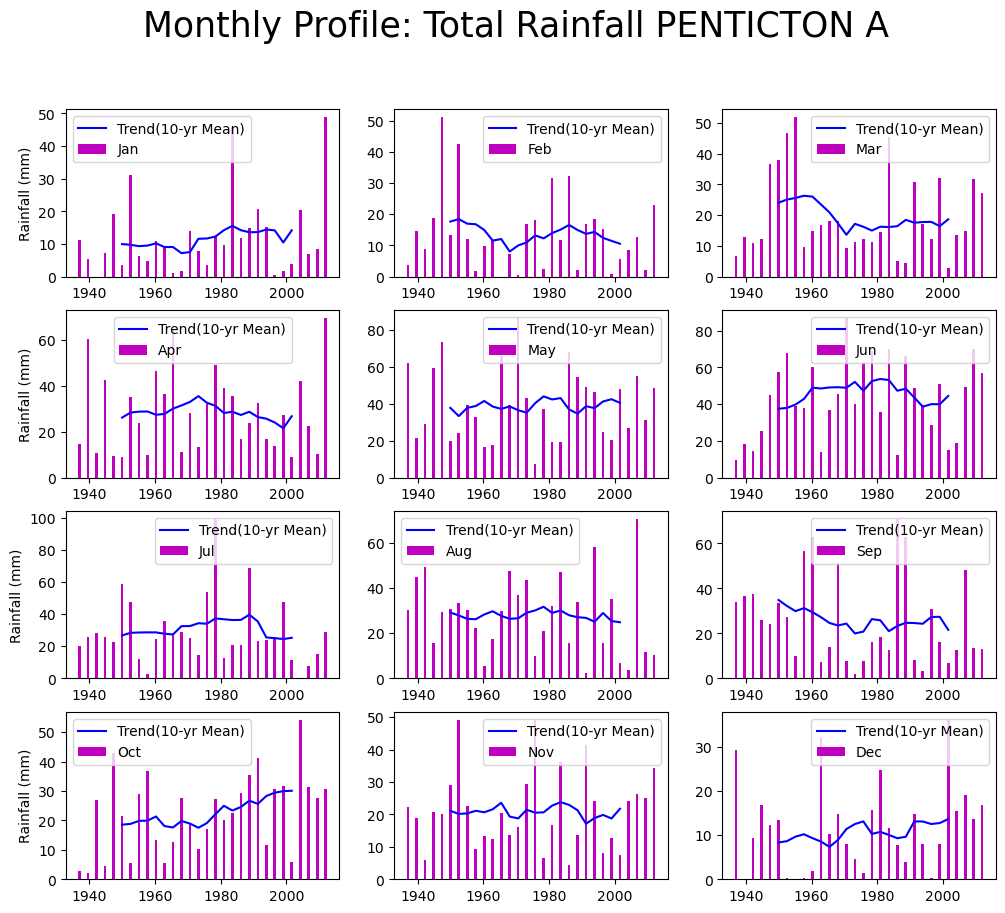

In [356]:
year_val = np.linspace(1937,2012,30)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    monthly_data = clean_interior_data[clean_interior_data['Month']==i+1]
    ax.bar(year_val,monthly_data.Total_Rain,label=months.get(i+1),color='m')
    window_10yrs = monthly_data['Total_Rain'].rolling(window=10,center=True,min_periods=10).mean()
    ax.plot(year_val,window_10yrs, color='b',label='Trend(10-yr Mean)')
    ax.legend()
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Monthly Profile: Total Rainfall {}'.format(clean_interior_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Annual Mean Rainfall Profile
This graph provides the results of the annual means for rainfall over a 10 year mean.

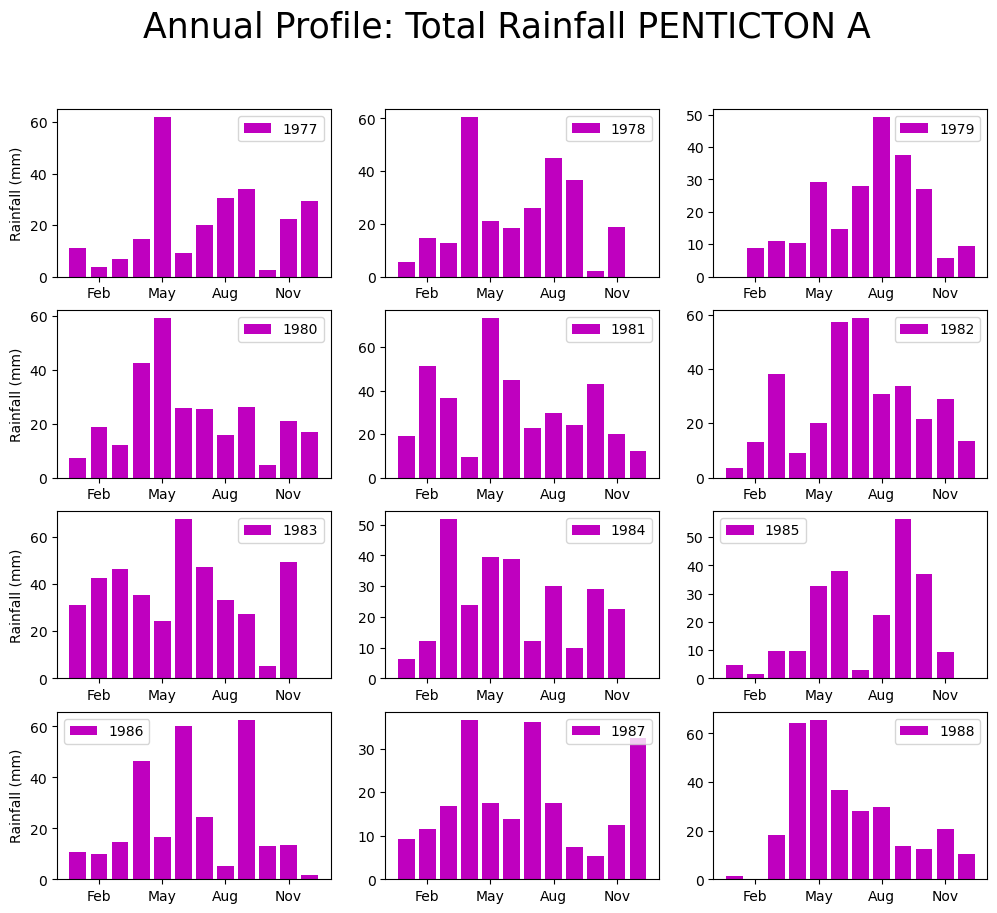

In [357]:
year = np.arange(1977,1989)
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(12,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    yearly_data = clean_interior_data[clean_interior_data['Year']==year[i]]
    ax.bar(months.values(),yearly_data.Total_Rain,label=year[i],color='m')
    ax.set_xticks(list(months.values())[1:12:3])
    ax.legend() 
    
axes[0].set_ylabel('Rainfall (mm)')
axes[3].set_ylabel('Rainfall (mm)')
axes[6].set_ylabel('Rainfall (mm)')
axes[9].set_ylabel('Rainfall (mm)')

fig.suptitle('Annual Profile: Total Rainfall {}'.format(clean_interior_data.iloc[0]['Station_Name']),fontsize=25)
    
plt.show()

### Monthly Mean
This section calculates the monhtly mean temperature and rainfall over the available years

In [358]:
Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\617222211.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Monthly_Mean = np.round(clean_coast_data.groupby('Month').mean(),1)


#### Mean Monthly Temperature

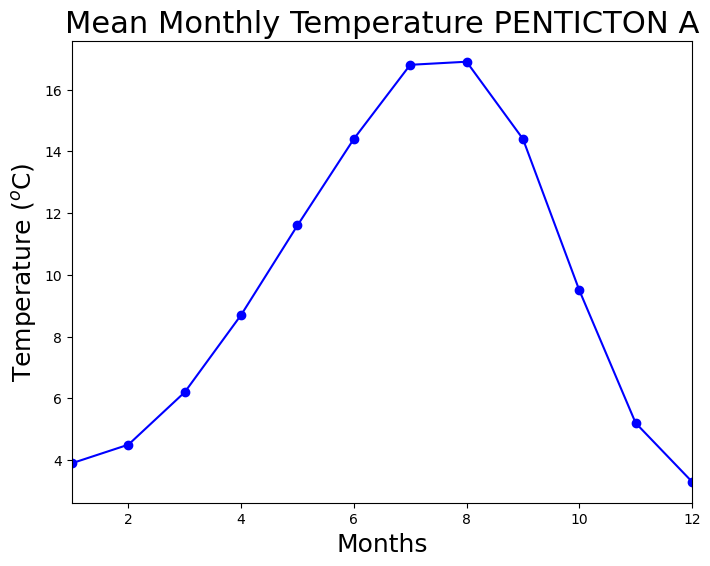

In [359]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(Monthly_Mean.index, Monthly_Mean.Mean_Temp,'bo-')
plt.xlim([1,12])
plt.ylabel('Temperature ($^{o}$C)',fontsize=18)
plt.xlabel('Months',fontsize=18)
plt.title('Mean Monthly Temperature {}'.format(clean_interior_data.iloc[0]['Station_Name']), fontsize=22)

plt.show()

#### Mean Monthly Rainfall

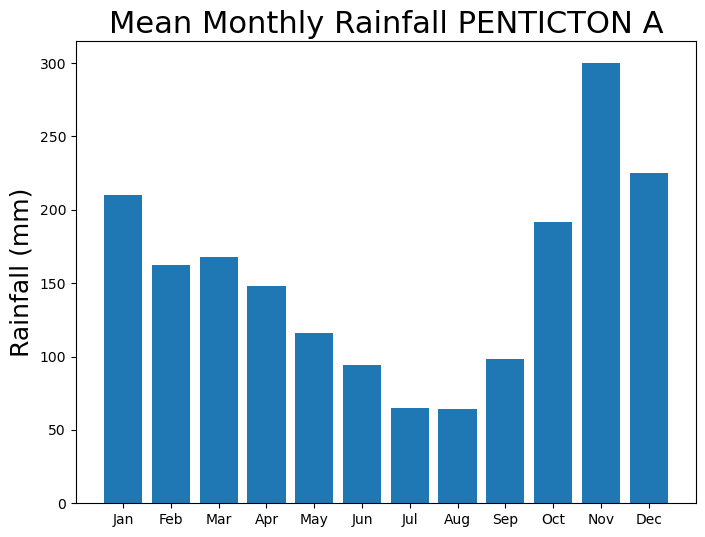

In [360]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.bar(months.values(), Monthly_Mean.Total_Rain)
plt.ylabel('Rainfall (mm)',fontsize=18)
plt.title('Mean Monthly Rainfall {}'.format(clean_interior_data.iloc[0]['Station_Name']), fontsize=22)
plt.show()

### Seasonal Means

In [361]:
month_num_2_season = {
    1:'DJF',
    2:'DJF',
    3:'MAM',
    4:'MAM',
    5:'MAM',
    6:'JJA',
    7:'JJA',
    8:'JJA',
    9:'SON',
    10:'SON',
    11:'SON',
    12:'DJF'
    
}

clean_interior_data['season'] = [month_num_2_season.get(i) for i in clean_interior_data.Month]

# calculate seasonal mean
seasonal_val = np.round(clean_interior_data.groupby('season').mean(),1)
seasonal_val


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3392295815.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_interior_data['season'] = [month_num_2_season.get(i) for i in clean_interior_data.Month]
C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3392295815.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_val = np.round(clean_interior_data.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1126150.0,-119.6,49.5,1991.5,5.0,-0.4,12.5
JJA,1126150.0,-119.6,49.5,1991.5,7.0,19.6,33.3
MAM,1126150.0,-119.6,49.5,1991.5,4.0,9.3,29.2
SON,1126150.0,-119.6,49.5,1991.5,10.0,9.0,23.2


### Data Visualization 10 years

In [362]:
interior_recent = clean_interior_data[clean_interior_data['Year'] >= 1995]
interior_recent

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,datetime,season
648,PENTICTON A,1126150,-119.6,49.46,1995,1,-0.6,45.4,1995-01-01,DJF
649,PENTICTON A,1126150,-119.6,49.46,1995,2,2.8,11.6,1995-02-01,DJF
650,PENTICTON A,1126150,-119.6,49.46,1995,3,3.9,45.4,1995-03-01,MAM
651,PENTICTON A,1126150,-119.6,49.46,1995,4,9.0,35.4,1995-04-01,MAM
652,PENTICTON A,1126150,-119.6,49.46,1995,5,15.5,19.2,1995-05-01,MAM
...,...,...,...,...,...,...,...,...,...,...
787,PENTICTON A,1126150,-119.6,49.46,2006,8,19.7,10.2,2006-08-01,JJA
788,PENTICTON A,1126150,-119.6,49.46,2006,9,15.9,13.0,2006-09-01,SON
789,PENTICTON A,1126150,-119.6,49.46,2006,10,9.2,30.6,2006-10-01,SON
790,PENTICTON A,1126150,-119.6,49.46,2006,11,2.6,34.3,2006-11-01,SON


In [363]:
monthly_mean_recent = interior_recent.groupby('Month').mean()
monthly_mean_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\281921945.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_mean_recent = interior_recent.groupby('Month').mean()


,Climate ID,lon,lat,Year,Mean_Temp,Total_Rain
Month,,,,,,
1,1126150.0,-119.6,49.46,2000.5,-0.283333,16.575000
2,1126150.0,-119.6,49.46,2000.5,1.100000,12.450000
3,1126150.0,-119.6,49.46,2000.5,4.766667,19.750000
4,1126150.0,-119.6,49.46,2000.5,9.325000,26.675000
5,1126150.0,-119.6,49.46,2000.5,13.841667,41.000000
6,1126150.0,-119.6,49.46,2000.5,17.641667,43.858333
7,1126150.0,-119.6,49.46,2000.5,21.366667,24.516667
8,1126150.0,-119.6,49.46,2000.5,20.508333,25.958333
9,1126150.0,-119.6,49.46,2000.5,15.425000,24.933333


#### Mean Temperature Change

In [364]:
diff_mean_temp = monthly_mean_recent.Mean_Temp - Monthly_Mean.Mean_Temp


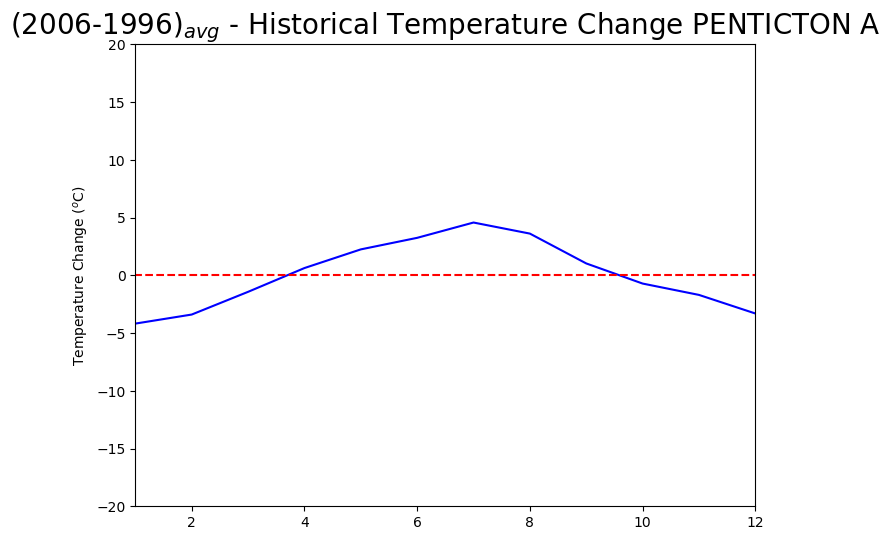

In [365]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_mean_temp,'b-')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1,12])
ax.set_ylim(-20,20)
ax.plot([0,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Temperature Change PENTICTON A', fontsize=20)
plt.show()

#### Mean Rainfall Change

In [366]:
diff_Total_Rainfall = monthly_mean_recent.Total_Rain - Monthly_Mean.Total_Rain

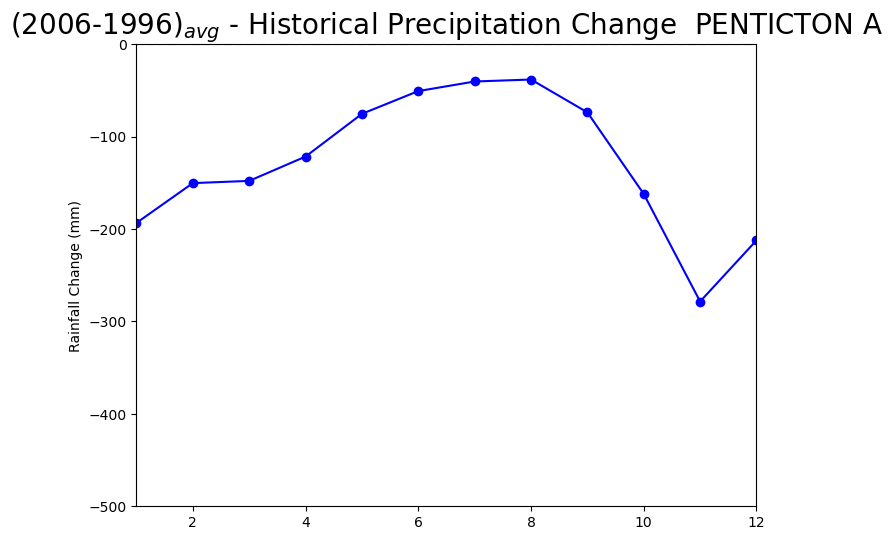

In [367]:
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
ax.plot(monthly_mean_recent.index,diff_Total_Rainfall,'ob-')
ax.set_ylabel('Rainfall Change (mm)')
ax.set_xlim([1,12])
ax.set_ylim(-500,0)
ax.plot([1,12],[0,0],'r--')
plt.title('(2006-1996)$_{avg}$ - Historical Precipitation Change  PENTICTON A', fontsize=20)
plt.show()

#### Seasonal Means

In [368]:
seasonal_recent = np.round(coastal_recent.groupby('season').mean(),1)
seasonal_recent

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\531591284.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  seasonal_recent = np.round(coastal_recent.groupby('season').mean(),1)


,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain
season,,,,,,,
DJF,1101158.0,-122.9,49.3,2000.5,5.0,4.2,203.3
JJA,1101158.0,-122.9,49.3,2000.5,7.0,16.5,67.4
MAM,1101158.0,-122.9,49.3,2000.5,4.0,8.6,148.3
SON,1101158.0,-122.9,49.3,2000.5,10.0,9.8,205.5


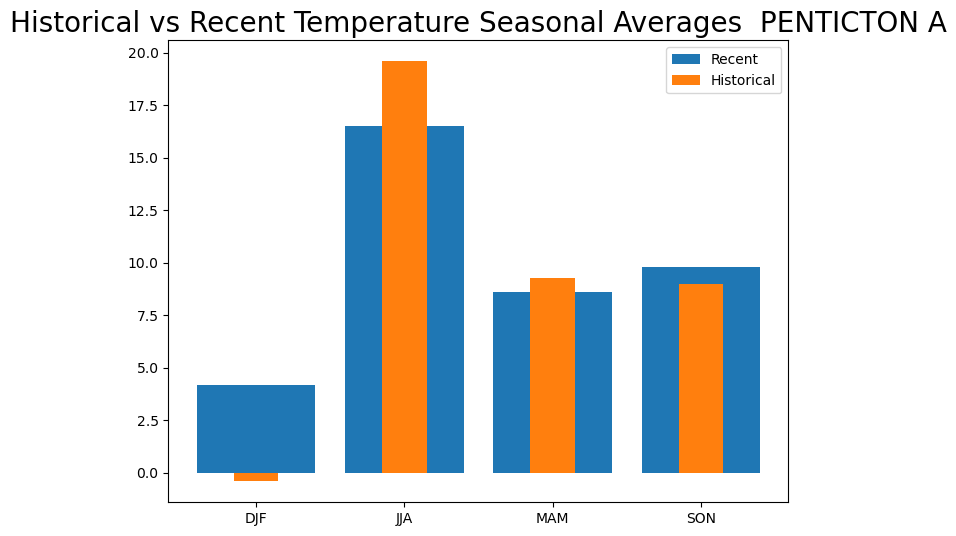

In [369]:
seasons_name = ['DJF','JJA','MAM','SON']
fig = plt.figure(figsize=(8,6),dpi=100)
ax = fig.add_subplot(111)
width=0.3
ax.bar(seasons_name,seasonal_recent.Mean_Temp,label='Recent')
ax.bar(seasons_name,seasonal_val.Mean_Temp,width,label='Historical')
ax.legend()
plt.title('Historical vs Recent Temperature Seasonal Averages  PENTICTON A', fontsize=20)
plt.show()

### Data Visualization 30 Years

In [370]:
interior_30 = clean_interior_data[clean_interior_data['Year'] >= 1976]
interior_30

,Station_Name,Climate ID,lon,lat,Year,Month,Mean_Temp,Total_Rain,datetime,season
432,PENTICTON A,1126150,-119.6,49.46,1977,1,-3.9,11.3,1977-01-01,DJF
433,PENTICTON A,1126150,-119.6,49.46,1977,2,2.0,3.8,1977-02-01,DJF
434,PENTICTON A,1126150,-119.6,49.46,1977,3,4.7,6.8,1977-03-01,MAM
435,PENTICTON A,1126150,-119.6,49.46,1977,4,10.1,14.5,1977-04-01,MAM
436,PENTICTON A,1126150,-119.6,49.46,1977,5,12.0,61.9,1977-05-01,MAM
...,...,...,...,...,...,...,...,...,...,...
787,PENTICTON A,1126150,-119.6,49.46,2006,8,19.7,10.2,2006-08-01,JJA
788,PENTICTON A,1126150,-119.6,49.46,2006,9,15.9,13.0,2006-09-01,SON
789,PENTICTON A,1126150,-119.6,49.46,2006,10,9.2,30.6,2006-10-01,SON
790,PENTICTON A,1126150,-119.6,49.46,2006,11,2.6,34.3,2006-11-01,SON


#### Mean Temperature Change

In [371]:
df_30yrs_Mean_Temp = np.round(interior_30.groupby('Year').mean().mean().Mean_Temp,2)
df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1559133115.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp = np.round(interior_30.groupby('Year').mean().mean().Mean_Temp,2)


9.38

In [372]:
Tdiff = clean_interior_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\3026043880.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff = clean_interior_data.groupby('Year').mean().Mean_Temp - df_30yrs_Mean_Temp


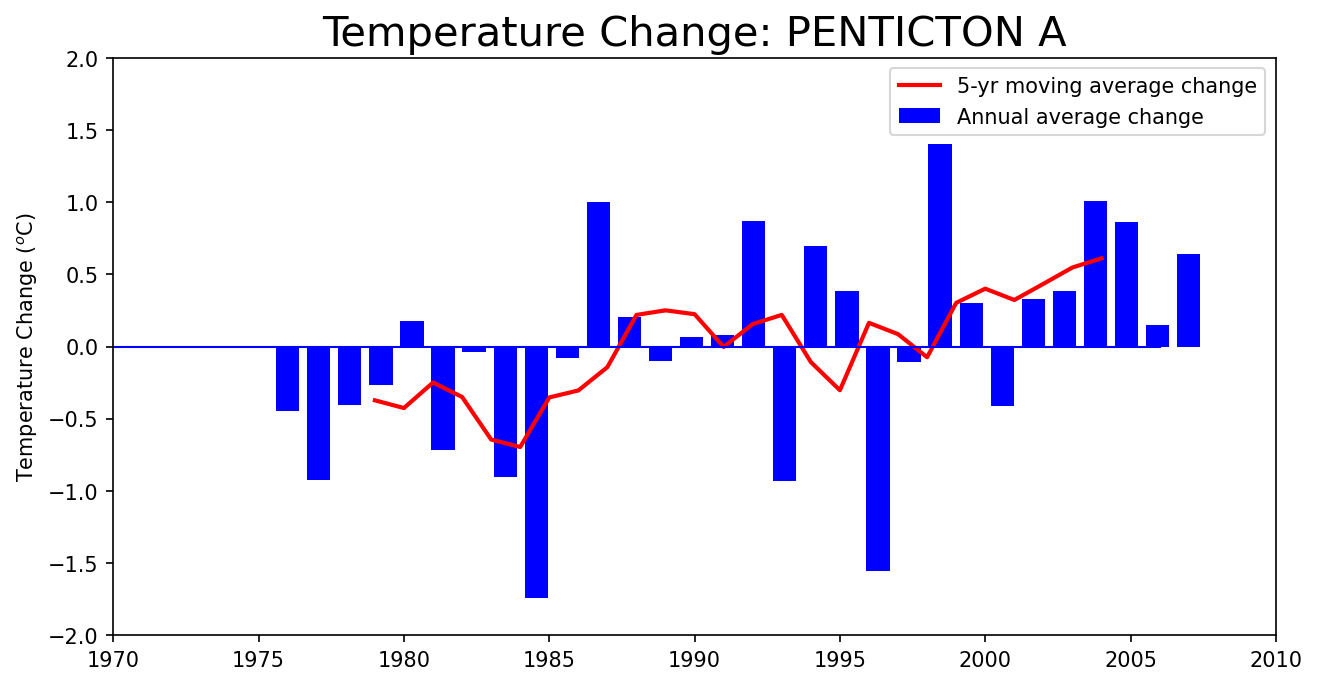

In [373]:
year_val = np.linspace(1976,2007,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1970,2010])
ax.plot(Tdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-2,2])


plt.title('Temperature Change: {}'.format(clean_interior_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

#### Mean Rain Change

In [374]:
df_30yrs_Total_Rain = np.round(clean_interior_data.groupby('Year').mean().mean().Total_Rain,2)
df_30yrs_Total_Rain

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\376733900.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Total_Rain = np.round(clean_interior_data.groupby('Year').mean().mean().Total_Rain,2)


24.53

In [375]:
Rdiff = clean_interior_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


C:\Users\santi\AppData\Local\Temp\ipykernel_34500\1390460375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Rdiff = clean_interior_data.groupby('Year').mean().Total_Rain - df_30yrs_Total_Rain


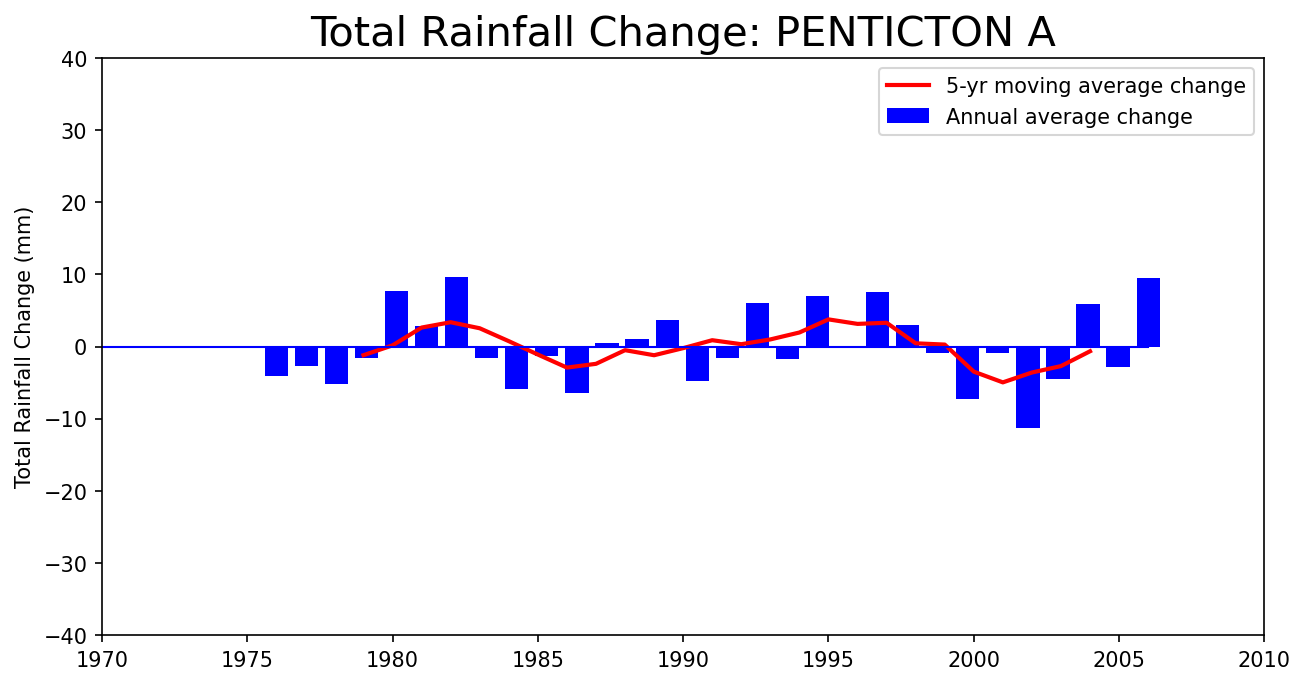

In [376]:
year_val = np.linspace(1976,2006,30)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Rdiff,color='b',label='Annual average change')
ax.set_ylabel('Total Rainfall Change (mm)')
ax.set_xlim([1970,2010])
ax.plot(Rdiff.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.set_ylim([-40,40])


plt.title('Total Rainfall Change: {}'.format(clean_interior_data.iloc[0]['Station_Name']), fontsize=20)
plt.legend()
plt.show()

# Global Analysis

On it's way

In [402]:
global_temp = pd.read_csv(r'D:\Above\web-dev\projects\climate_analysis_ENSC304\1960-2023.csv')

In [431]:
global_temp['datetime'] = pd.to_datetime(global_temp['Year'], format='%Y%m', errors='ignore')
global_temp_clean['year'] = global_temp['datetime'].dt.strftime('%Y')
global_temp_clean['month'] = global_temp['datetime'].dt.strftime('%m')
global_temp_clean.to_csv('global_temp_clean2.csv')

In [423]:
df_30yrs_Mean_Temp_glob = np.round(global_temp_clean.groupby('year').mean().mean().Value,2)
df_30yrs_Mean_Temp_glob

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2613886671.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_30yrs_Mean_Temp_glob = np.round(global_temp_clean.groupby('year').mean().mean().Value,2)


0.4

In [425]:
Tdiff_global = global_temp_clean.groupby('year').mean().Value - df_30yrs_Mean_Temp_glob

C:\Users\santi\AppData\Local\Temp\ipykernel_34500\2268362933.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Tdiff_global = global_temp_clean.groupby('year').mean().Value - df_30yrs_Mean_Temp_glob


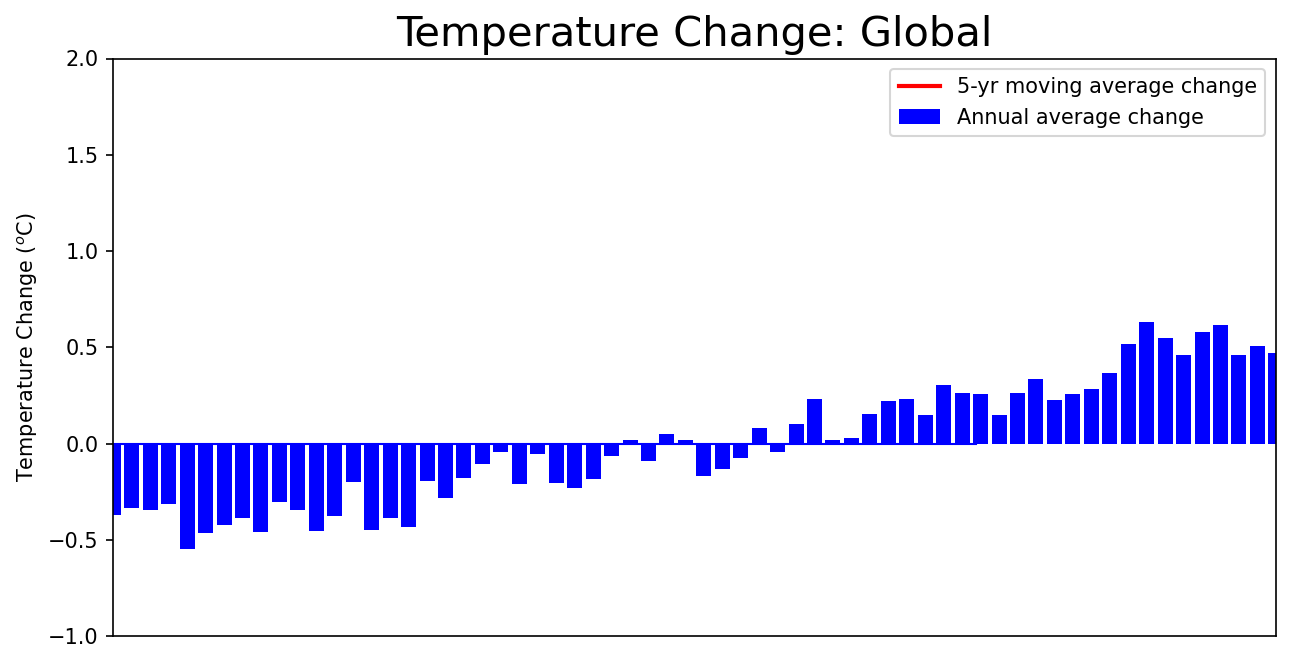

In [428]:
year_val = np.linspace(1960,2022,64)
fig = plt.figure(figsize=(10,5),dpi=150)
ax = fig.add_subplot(111)
ax.bar(year_val,Tdiff_global,color='b',label='Annual average change')
ax.set_ylabel('Temperature Change ($^o$C)')
ax.set_xlim([1960,2022])
ax.plot([0,2006],[0,0],color='b',linewidth=1)
ax.plot(Tdiff_global.rolling(window=5,min_periods=5,center=True).mean(),label= '5-yr moving average change',color='r',linewidth=2)
ax.set_ylim([-1,2])


plt.title('Temperature Change: Global', fontsize=20)
plt.legend()
plt.show()